ELO Rating System

# Introduction 

The Study aimed to solve the following tasks: 

1. The development of a rating system is a common task in sport. Particularly, the
ELO rating system (https://en.wikipedia.org/wiki/Elo_rating_system)
is a particular popular one.

    • Develop a function to implement the ELO Rating System with arbitrary
    K and s.

    • Apply the rating system to 1. Bundesliga 2015/2016 season with starting
    values R0 = 100, s = 15 and K = 15.

    • Develop an approach that finds the optimal values for s and K based on
    that season and display the final ranking table at the end of the season.

    • Develop and implement a strategy for quantifying the single most surpris-
    ing win among men’s match results in the 2015/2016 Season. Summarize



# Methodology 

This section describe the methdological approach aiming to solve the above tasks. 

## Dataset and Preprocessing Step

The datasets used in this study is from Bundesliga 2015/2016. In total two datasets are used in this study to prepare three datasets used in this study. The first dataset name *df* consists each week Matches score, Teams name, match date and Week [1,2]. Another dataset name *previous_year_rank_df* consists the final ranking of the teams in season 2014/2015 [2]. Then First prepared dataset called *match_df* which is mainly used in development of ELO systems were prepared by combining *df* and *previous_year_rank_df*. The match_df dataset is further used to prepared the second dataset name *weekly rankings* by adding weekly ranking of teams based on their win, loss, goal scored, and conceded for each week. This dataset used to validate ELO system performance for weekly rank predictions. 

Further, third dataset was prepared from *match_df* name *final_actual_rank* which consists seasons last week ranks, teams name, team total points, goal scored. This dataset is used for validate ELO system ranking based on the last week. The three code sections below consists the prepration code for all three dataframe.

match_df

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skopt import gp_minimize
from skopt.space import Real, Integer
from scipy.optimize import basinhopping
import numpy as np
from sklearn.model_selection import ParameterGrid

file_path = 
df = pd.read_csv(file_path, sep=';')
df['Home'] = df['Home'].str.replace('Kšln', 'Koln')
df['Away'] = df['Away'].str.replace('Kšln', 'Koln')
# Main Dataframe consists Week, Date, Home team name, Home Score, Away team name, and Away Score (Source: https://fbref.com/en/comps/20/2015-2016/schedule/2015-2016-Bundesliga-Scores-and-Fixtures)
file_p = 
previous_year_rank_df = pd.read_excel(file_p)
previous_year_rank_df = previous_year_rank_df.rename(columns={'Teams': 'Home', 'Rank': 'Previous_year_ranking'})
match_df = pd.merge(df, previous_year_rank_df[['Home', 'Previous_year_ranking']], on='Home', how='left')
match_df

,Wk,Date,Home,Home Score,Away,Away Score,Previous_year_ranking
0,1,14.08.15,Bayern Munich,5,Hamburger SV,0,1
1,1,15.08.15,Augsburg,0,Hertha BSC,1,5
2,1,15.08.15,Leverkusen,2,Hoffenheim,1,4
3,1,15.08.15,Darmstadt 98,2,Hannover 96,2,20
4,1,15.08.15,Mainz 05,0,Ingolstadt 04,1,11
...,...,...,...,...,...,...,...
301,34,14.05.16,Werder Bremen,1,Eint Frankfurt,0,10
302,34,14.05.16,Augsburg,1,Hamburger SV,3,5
303,34,14.05.16,Mainz 05,0,Hertha BSC,0,11
304,34,14.05.16,Bayern Munich,3,Hannover 96,1,1


Weekly_rankings

In [3]:

# This fucntion calculate the total points for each team based on goals_scored,conceded, difference and number of matches.
def update_team_stats(team, stats, goals_scored, goals_conceded, result):
    stats[team]['matches'] += 1
    stats[team]['goals_scored'] += goals_scored
    stats[team]['goals_conceded'] += goals_conceded
    stats[team]['goal_difference'] = stats[team]['goals_scored'] - stats[team]['goals_conceded']
    
    if result == 'win':
        stats[team]['points'] += 3
    elif result == 'draw':
        stats[team]['points'] += 1

# This function calculate the weekly ranking of all the teams
def calculate_weekly_rankings(teams_stats):
    teams_df = pd.DataFrame(teams_stats).T 
    teams_df = teams_df.sort_values(by=['points', 'goal_difference', 'goals_scored'], ascending=[False, False, False])
    teams_df['rank'] = range(1, len(teams_df) + 1)
    return teams_df[['points', 'goal_difference', 'goals_scored', 'rank']]

# This function calculates points for each week, teams ranking and create a dataframe.
def process_matches_with_rankings(df):
    teams = set(df['Home']).union(set(df['Away']))
    total_matches = df['Wk'].max()
    teams_stats = {team: {'matches': 0, 'points': 0, 'goals_scored': 0, 'goals_conceded': 0, 'goal_difference': 0} for team in teams}
    weekly_rankings = []

    for week in range(1, total_matches + 1):
        weekly_df = df[df['Wk'] == week]
        
        for _, row in weekly_df.iterrows():
            home_team = row['Home']
            away_team = row['Away']
            home_goals = row['Home Score']
            away_goals = row['Away Score']

            if home_goals > away_goals:
                home_result = 'win'
                away_result = 'loss'
            elif home_goals == away_goals:
                home_result = 'draw'
                away_result = 'draw'
            else:
                home_result = 'loss'
                away_result = 'win'

            # Update teams points
            update_team_stats(home_team, teams_stats, home_goals, away_goals, home_result)
            update_team_stats(away_team, teams_stats, away_goals, home_goals, away_result)

        # Calculate rankings after each team has played at least 2 matches
        if all(stats['matches'] >= 2 for stats in teams_stats.values()):
            week_ranking = calculate_weekly_rankings(teams_stats)
            week_ranking['Wk'] = week
            weekly_rankings.append(week_ranking)

    # Final DF
    ranking_df = pd.concat(weekly_rankings)
    return ranking_df.reset_index().rename(columns={'index': 'Team'})


weekly_rankings = process_matches_with_rankings(df)
# This dataframe calculate from the base dataframe (match_df) with the function name process_matches_with_ranking. The Data Frame Consists folowing columns:

# 1. Team: Teams Name
# 2. Points: Points calculated by function update_team_stats
# 3. Goal Difference: Goal Scored - Goal Conceded
# 4. Goal Scored: Goal scored
# 5. Rank: Weekly rank calculated by function calculate_weekly_rankings
# 6. Week: Week number

Final Season Ranking

In [4]:
final_week = 34
final_actual_rank = weekly_rankings[weekly_rankings['Wk'] == 34][['Team', 'rank']].rename(columns={'rank': 'Actual_Rank'}).reset_index(drop=True)

## ELO system

According to Wikipedia [3], " The Elo rating system is a method for calculating the relative skill levels of players in zero-sum games such as chess or esports. It is named after its creator, Arpad Elo, a Hungarian-American physics professor."

The ELO System consists of three crucial variables: K-Factor, E (Expected Score), and S (Fractional Score). The most critical part of ELO, especially in the context of modeling for any sports ranking system, is the K-Factor. The K-factor is a value that aims to balance the stability and sensitivity of the ranking system, which means if the K-factor value is high, then ranking prediction might be affected by a few events. On the other hand, if the k factor is too low, then a vital event effect cannot be captured.

The K factor and S scaling factor vary in each sport. Different ranking systems use diverse proportions for K factor values. For instance, FIDE uses K = 40, K= 20, and K = 10 for three different category of players. The S scaling factor helps balance the K factor and allows the K factor to capture the sports-specific nature. 


## Experiment Approach

This experimental study aims to identify the most effective ELO ranking system for predicting the final season teams’ rank and weekly team ranks. Root mean squared error statistical technique used in this study to compare the models performance. 

For this, first, the optimal value of k and s is searched based on hyperparameter techniques like (grid search, random search, and Bayesian optimization). The K and S values will be selected based on lowest RMSE values for final week prediction and will be used to develop the First ELO system called **Optimized ELO Model**. Then, a comparision is established to check if the optimized ELO system outperforms the basic ELO system with arbitrary K and S values. Further, the optimized ELO system is used to calculate weekly rank predictions to check the performance of the optimized ELO system during weekly rank predictions.

Later, intensive data science methods like feature visualization and trend analysis are performed to find possible factors that limits the optimized K and S value to capture the real ranking prediction. Based on the identified possible factors a new apporach will be develop to calculate K factor which increase the stability of the ELO system predict the best final ranking and weekly team's ranking. The model will be called as **Final optimized ELO Model**.

The following coding implementation below showcases the ELO systems. The main ELO function, *update_elo_rating_basic*, is a key component of the experiment. It was used as the baseline ELO model which further has update versions based on several grid search methods, feature enginnering. There are three major Experiments which consists several different trials to identify three models.


### Basic ELO described in Wikipedia

In [9]:
def expected_outcome_basic(R_team, R_opponent):
    """
    Calculate the expected outcome for a team based on basic Elo ratings.
    Returns a value between 0 and 1, where 0.5 indicates an equal chance.
    """
    return 1 / (1 + 10 ** ((R_opponent - R_team) / 400))

def update_elo_rating_basic(R_old, S, E, K):
    """
    Updates the ELO rating using the basic formula:
    R_new = R_old + K * (S - E)
    
    R_old: The old Elo rating of the team
    S: The score (1 for win, 0 for loss, 0.5 for draw)
    E: The expected score based on ratings (from the expected_outcome_basic function)
    K: The K-factor, a constant that determines how much the ratings adjust
    """
    return R_old + K * (S - E)

def calculate_end_of_season_elo_ratings(df, K, initial_rating=100):
    """
    Calculate end-of-season Elo ratings for all teams.
    
    df: The match dataframe
    K: The K-factor to use for rating updates
    initial_rating: The initial Elo rating for all teams
    """
    elo_ratings = {team: initial_rating for team in pd.concat([df['Home'], df['Away']]).unique()}
    
    for index, row in df.iterrows():
        home_team = row['Home']
        away_team = row['Away']
        home_goals = row['Home Score']
        away_goals = row['Away Score']

        if home_goals > away_goals:
            S_home, S_away = 1, 0
        elif home_goals == away_goals:
            S_home, S_away = 0.5, 0.5
        else:
            S_home, S_away = 0, 1

        R_home = elo_ratings[home_team]
        R_away = elo_ratings[away_team]

        E_home = expected_outcome_basic(R_home, R_away)
        E_away = expected_outcome_basic(R_away, R_home)

        elo_ratings[home_team] = update_elo_rating_basic(R_home, S_home, E_home, K)
        elo_ratings[away_team] = update_elo_rating_basic(R_away, S_away, E_away, K)

    final_elo_ratings = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Rating'])
    
    final_elo_ratings['Rank'] = final_elo_ratings['Rating'].rank(ascending=False, method='min')

    return final_elo_ratings


K = 15 # Arbitary K value
final_elo_ratings_initial = calculate_end_of_season_elo_ratings(match_df, K=K, initial_rating=100)
print(final_elo_ratings_initial)


              Team      Rating  Rank
0    Bayern Munich  236.566594   1.0
1         Augsburg   78.173881  10.0
2       Leverkusen  149.052301   3.0
3     Darmstadt 98   72.517150  14.0
4         Mainz 05  109.057138   6.0
5    Werder Bremen   72.376648  15.0
6         Dortmund  203.110284   2.0
7        Wolfsburg   87.296394   9.0
8        Stuttgart   43.649890  17.0
9       Hertha BSC  102.889634   7.0
10  Eint Frankfurt   65.729957  16.0
11     Hannover 96   17.215808  18.0
12      Schalke 04  116.041901   5.0
13      Hoffenheim   74.472724  12.0
14            Koln   94.360518   8.0
15    Hamburger SV   76.398984  11.0
16   Ingolstadt 04   73.964363  13.0
17        Gladbach  127.125831   4.0


In [10]:

final_comparison = pd.merge(final_elo_ratings_initial[['Team', 'Rank']], final_actual_rank, on='Team', how='left')
final_comparison['Rank_Difference'] = final_comparison['Actual_Rank'] - final_comparison['Rank']
final_comparison = final_comparison.sort_values(by='Rank_Difference', ascending=False)
print("Teams with biggest Elo/Actual Rank difference:")
print(final_comparison.head(20))
final_comparison

Teams with biggest Elo/Actual Rank difference:
              Team  Rank  Actual_Rank  Rank_Difference
13      Hoffenheim  12.0           15              3.0
1         Augsburg  10.0           12              2.0
14            Koln   8.0            9              1.0
0    Bayern Munich   1.0            1              0.0
8        Stuttgart  17.0           17              0.0
12      Schalke 04   5.0            5              0.0
11     Hannover 96  18.0           18              0.0
10  Eint Frankfurt  16.0           16              0.0
9       Hertha BSC   7.0            7              0.0
6         Dortmund   2.0            2              0.0
4         Mainz 05   6.0            6              0.0
3     Darmstadt 98  14.0           14              0.0
2       Leverkusen   3.0            3              0.0
17        Gladbach   4.0            4              0.0
7        Wolfsburg   9.0            8             -1.0
15    Hamburger SV  11.0           10             -1.0
5    Werder Bremen

,Team,Rank,Actual_Rank,Rank_Difference
13,Hoffenheim,12.0,15,3.0
1,Augsburg,10.0,12,2.0
14,Koln,8.0,9,1.0
0,Bayern Munich,1.0,1,0.0
8,Stuttgart,17.0,17,0.0
12,Schalke 04,5.0,5,0.0
11,Hannover 96,18.0,18,0.0
10,Eint Frankfurt,16.0,16,0.0
9,Hertha BSC,7.0,7,0.0
6,Dortmund,2.0,2,0.0


# Results

The first result from above code bar indicates the performance of intial ELO system by using the the initial K = 15 and S = 15 to predict the teams ELO values and ranks. There are 7 rank differences detetcted than actual team ranks. Further 3 teams are predicted higher than the actual ranks and four teams below rank than their actual rank.  

The code bar section section below shows the RMSE value 1.154 of this ELO model.

In [11]:
def calculate_rmse(df):
    df['Squared_Difference'] = df['Rank_Difference'] ** 2
    mean_squared_difference = df['Squared_Difference'].mean()
    rmse = np.sqrt(mean_squared_difference)
    return rmse

rmse_initial = calculate_rmse(final_comparison)
print(f"RMSE: {rmse_initial}")

RMSE: 1.1547005383792515


## Experiment 1

### Trial 1

This experiment aimed to find the optimal value for of K and S. The grid search was initiated with the result of K value (15, 50) and S(15, 5000) aiming to have least RMSE for weekly team rank predictions. The elo rating prediction was used to caluclate rmse with actual rank. The lowest RMSE K and S parameters selected for the final prediction. 

In [12]:

def expected_outcome_elo(R_team, R_opponent, s=400):
    """
    Calculate the expected outcome based on Elo ratings.
    Returns a value between 0 and 1.
    """
    return 1 / (1 + 10 ** ((R_opponent - R_team) / s))

def update_elo_rating(R_old, S, E, K):
    """
    Update Elo rating using the formula: R_new = R_old + K * (S - E)
    """
    return R_old + K * (S - E)

# Include Weekly rank prediction and in the end final season prediction
def apply_elo_to_season(matches, K=15, s=15, initial_rating=100):
    """
    Apply Elo rating system to a season's matches and rank teams at the end of the season.
    matches: DataFrame containing the match results
    """
    teams = pd.concat([matches['Home'], matches['Away']]).unique()
    elo_ratings = {team: initial_rating for team in teams}
    
    total_weeks = matches['Wk'].max()
    
    for week in range(1, total_weeks + 1):
        weekly_matches = matches[matches['Wk'] == week]
        
        for index, row in weekly_matches.iterrows():
            home_team = row['Home']
            away_team = row['Away']
            home_goals = row['Home Score']
            away_goals = row['Away Score']

            # Determine match result
            if home_goals > away_goals:
                S_home, S_away = 1, 0
            elif home_goals == away_goals:
                S_home, S_away = 0.5, 0.5
            else:
                S_home, S_away = 0, 1

            R_home = elo_ratings[home_team]
            R_away = elo_ratings[away_team]

            E_home = expected_outcome_elo(R_home, R_away, s)
            E_away = expected_outcome_elo(R_away, R_home, s)

            elo_ratings[home_team] = update_elo_rating(R_home, S_home, E_home, K)
            elo_ratings[away_team] = update_elo_rating(R_away, S_away, E_away, K)

    final_ratings = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo'])
    final_ratings['Rank'] = final_ratings['Elo'].rank(ascending=False, method='min')
    final_ratings = final_ratings.sort_values(by='Rank')
    
    return final_ratings

final_elo_ratings = apply_elo_to_season(match_df, K=15, s=15, initial_rating=100)
print(final_elo_ratings)


def calculate_rmse(pred_ranks_df, actual_ranks_df):
    """
    Calculate RMSE between the predicted ranks (Elo-based) and actual ranks.
    """
    merged_df = pd.merge(pred_ranks_df, actual_ranks_df, on='Team', suffixes=('_elo', '_actual'))
    merged_df['rank_diff'] = merged_df['Rank'] - merged_df['Actual_Rank']
    rmse = np.sqrt(np.mean(merged_df['rank_diff'] ** 2))
    return rmse, merged_df

# Basic Grid search method used to search the values in the space
def grid_search_for_optimal_K_and_S(matches, actual_ranks_df, initial_rating=100, K_range=(5, 40), S_range=(15, 100), step=1):
    """
    Perform a grid search to find the optimal K and S values that minimize the RMSE
    between predicted Elo ranks and actual ranks.
    
    matches: DataFrame containing the match results
    actual_ranks_df: DataFrame containing the actual final ranks (final_actual_rank)
    initial_rating: Starting Elo rating for all teams
    K_range: Tuple (min_K, max_K) for the range of K values to explore
    S_range: Tuple (min_S, max_S) for the range of S values to explore
    step: Step size for K and S values during the grid search
    """
    best_rmse = float('inf')
    best_K, best_S = None, None
    results = []
    for K in range(K_range[0], K_range[1] + 1, step):
        for S in np.arange(S_range[0], S_range[1] + step, step):
            predicted_ranks = apply_elo_to_season(matches, K, S, initial_rating)
            rmse, _ = calculate_rmse(predicted_ranks, actual_ranks_df)
            results.append((K, S, rmse))
            if rmse < best_rmse:
                best_rmse = rmse
                best_K = K
                best_S = S
    
    print(f"Best K: {best_K}, Best S: {best_S}, RMSE: {best_rmse}")
    return best_K, best_S, best_rmse, results

best_K, best_S, best_rmse, results = grid_search_for_optimal_K_and_S(
    matches=match_df, 
    actual_ranks_df=final_actual_rank, 
    initial_rating=100,
    K_range=(15, 40),
    S_range=(1, 5000),
    step=4
)

# Display the best K, S, and corresponding RMSE
print(f"Optimal K: {best_K}, Optimal S: {best_S}, RMSE: {best_rmse}")


              Team         Elo  Rank
17        Gladbach  119.256246   1.0
5    Werder Bremen  117.325608   2.0
0    Bayern Munich  115.286875   3.0
12      Schalke 04  110.249651   4.0
10  Eint Frankfurt  105.792199   5.0
6         Dortmund  105.689099   6.0
14            Koln  105.357665   7.0
2       Leverkusen  104.791526   8.0
11     Hannover 96  100.557829   9.0
7        Wolfsburg   98.128545  10.0
3     Darmstadt 98   97.147549  11.0
15    Hamburger SV   96.802878  12.0
1         Augsburg   94.286453  13.0
13      Hoffenheim   89.494287  14.0
4         Mainz 05   88.182061  15.0
9       Hertha BSC   87.955994  16.0
16   Ingolstadt 04   86.235838  17.0
8        Stuttgart   77.459697  18.0
Best K: 15, Best S: 733, RMSE: 0.6666666666666666
Optimal K: 15, Optimal S: 733, RMSE: 0.6666666666666666


### Experiment 1 Trial 1 result

Based on the above experiment optimal value suggested by the grid search is K = 15 and S = 733 with best average RMSE for final rank predicition: 0.6666

## Experiment 1

### Trial 2

In this experiment, the aim is to use adavnce search methods like Bayesian optimization method and another technique (basin hopping) to find the optimal values for K and S which capture much more factors involved. 

Best K: 35, Best S: 1835.164463871772, RMSE: 0.6666666666666666


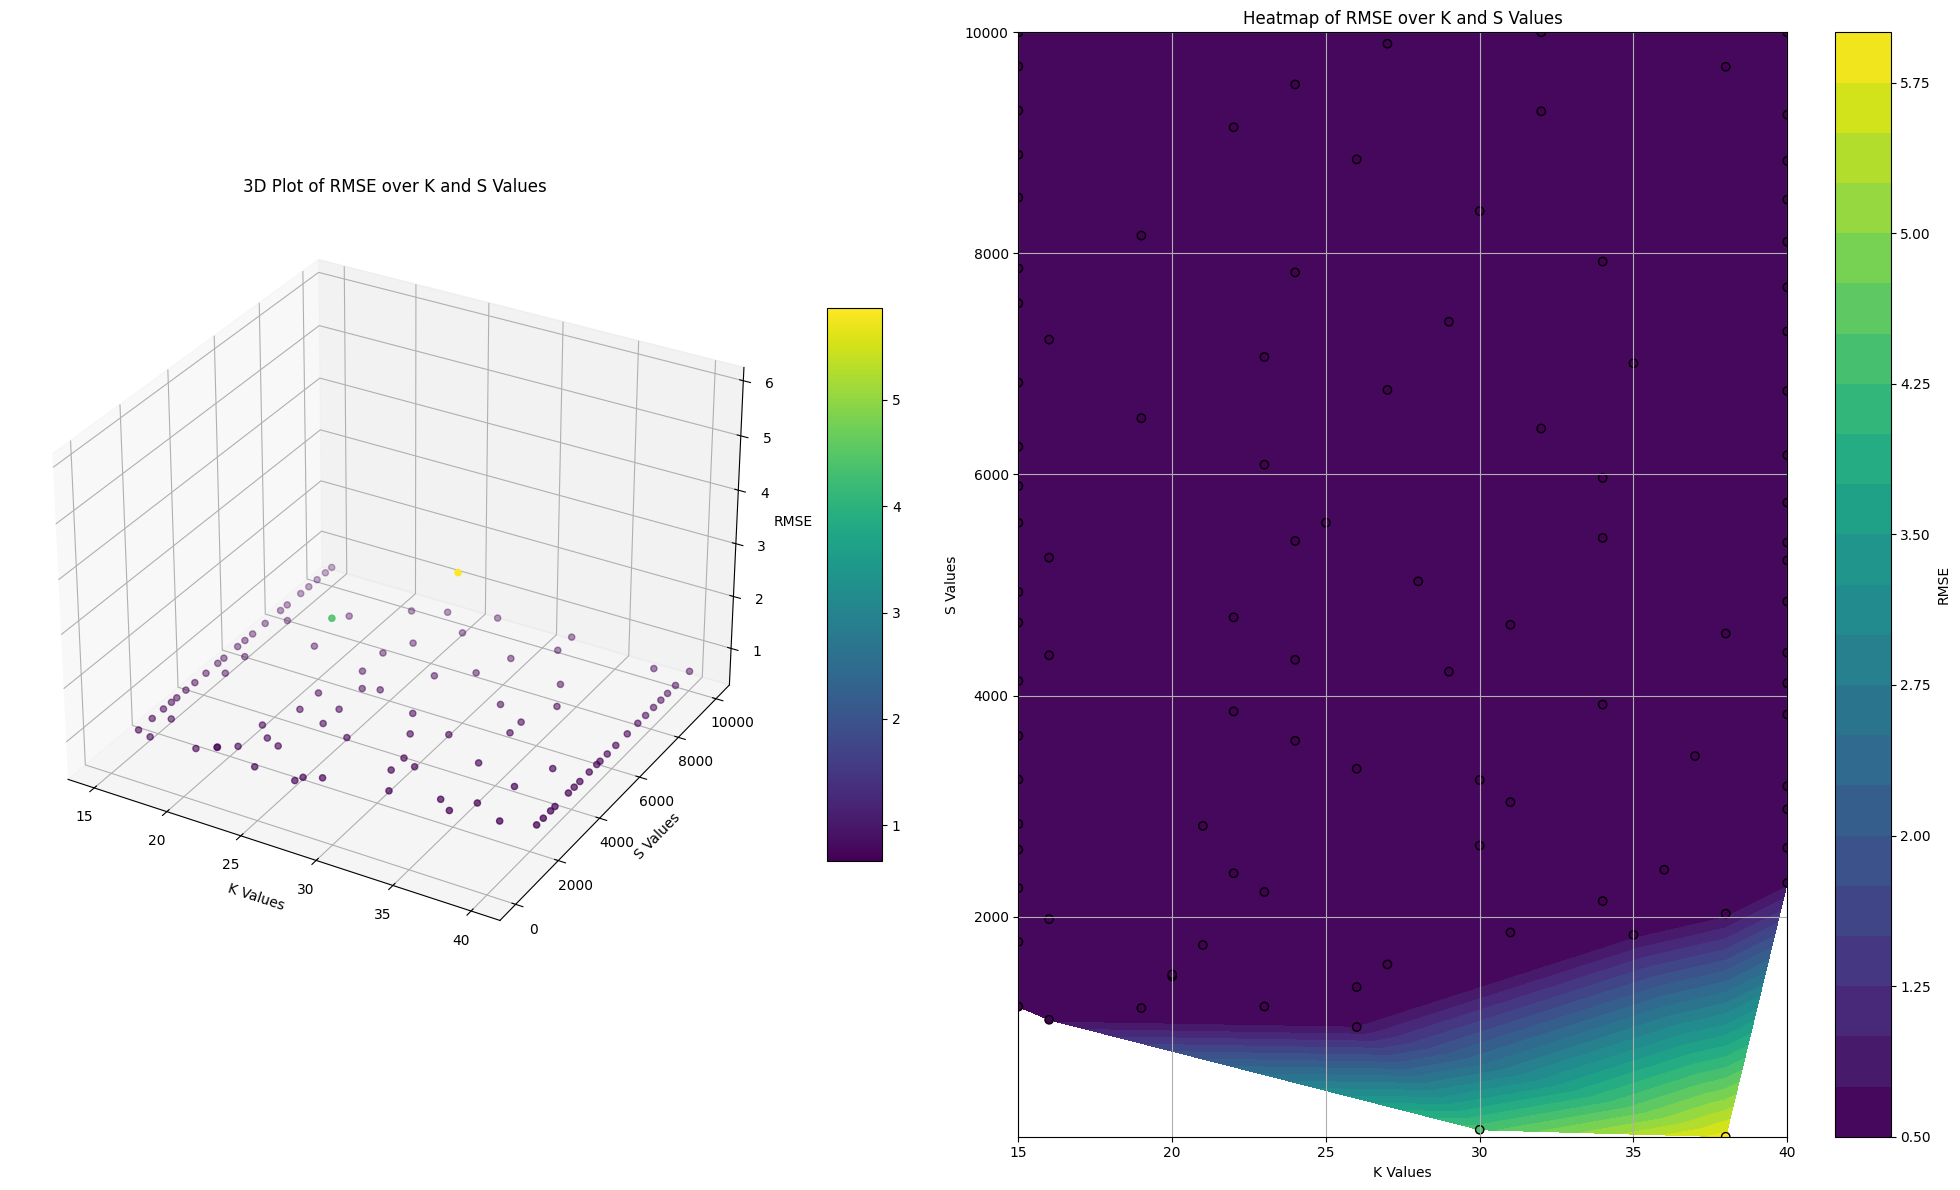

In [13]:

history = []

def objective(params):
    K, S = params
    predicted_ranks = apply_elo_to_season(match_df, K, S, initial_rating=100)
    rmse, _ = calculate_rmse(predicted_ranks, final_actual_rank)
    
    # Store K, S, and RMSE
    history.append((K, S, rmse))
    
    return rmse

# Definitation of Space Boundaries
space = [Integer(15, 40, name='K'), Real(1, 10000, name='S')]

# Bayesian optimization
result = gp_minimize(objective, space, n_calls=100, random_state=42)
print(f"Best K: {result.x[0]}, Best S: {result.x[1]}, RMSE: {result.fun}")

# Extract K, S, and RMSE values from history
K_vals, S_vals, RMSE_vals = zip(*history)

# Plotting the K, S and RMSE values
K_vals = np.array(K_vals)
S_vals = np.array(S_vals)
RMSE_vals = np.array(RMSE_vals)
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(121, projection='3d')
scat = ax1.scatter(K_vals, S_vals, RMSE_vals, c=RMSE_vals, cmap='viridis', marker='o')
ax1.set_xlabel('K Values')
ax1.set_ylabel('S Values')
ax1.set_zlabel('RMSE')
plt.title('3D Plot of RMSE over K and S Values')
fig.colorbar(scat, ax=ax1, shrink=0.5, aspect=10)
# Heatmap 
ax2 = fig.add_subplot(122)
contour = ax2.tricontourf(K_vals, S_vals, RMSE_vals, levels=20, cmap='viridis')
plt.colorbar(contour, ax=ax2, label='RMSE')
ax2.scatter(K_vals, S_vals, c=RMSE_vals, cmap='viridis', marker='o', edgecolors='black')
ax2.set_xlabel('K Values')
ax2.set_ylabel('S Values')
ax2.set_title('Heatmap of RMSE over K and S Values')
ax2.grid(True)
plt.tight_layout()
plt.show()


### Experiment 1 Trial 2 results

**The Bayesian optimization results suggested K = 35 and S: 1835.164463871772 with RMSE score of 0.666 at the end of the season. The RMSE values of both Grid search and Bayesian Optimizsation is similar. However, based on above plot we can see K = 15 is on left boundary consists lesser dots with low RMSE in comparision to region around 30 to 40. Hence, Bayesian optimzation values of K and S was decided to be use in optimized ELO model.**

## Experiment 2 Trial 3 results

The use of Basinhoppin technique for finding best K and S values.

In [14]:

def objective(params):
    K, S = params
    predicted_ranks = apply_elo_to_season(match_df, K, S, initial_rating=100)
    rmse, _ = calculate_rmse(predicted_ranks, final_actual_rank)
    return rmse

initial_guess = [15, 700]
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": [(15, 40), (1, 5000)]}

result = basinhopping(objective, initial_guess, minimizer_kwargs=minimizer_kwargs, niter=100)

print(f"Best K: {result.x[0]}, Best S: {result.x[1]}, RMSE: {result.fun}")


Best K: 15.0, Best S: 700.0, RMSE: 0.7453559924999299


### Experiment 1 Trial 3 result

The basin hopping results suggested K = 15 and S = 700 with RMSE of 0.7435 at the end of the season. The results are not good as grid search results. Hence, the use of the values were not proceed further.

## Experiment 1

### Trial 4

Its usually important to understand the space boundaries as having a good space helps to explore better possibility to find good hyparparamter values. In this experiment, the approach is check if log scale can help identify a better space for S scaling factor.

In [15]:
def grid_search_for_optimal_K_and_log_S(matches, actual_ranks_df, initial_rating=100, K_range=(15, 40), S_log_range=(0, 100), step=0.5):
    best_rmse = float('inf')
    best_K, best_S = None, None
    results = []
    K_values = np.arange(K_range[0], K_range[1], step=1)  # Integer range for K
    S_values = [10**x for x in np.arange(S_log_range[0], S_log_range[1], step)]
    
    for K in K_values:
        for S in S_values:
            predicted_ranks = apply_elo_to_season(matches, K, S, initial_rating)
            rmse, _ = calculate_rmse(predicted_ranks, actual_ranks_df)
            results.append((K, S, rmse))
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_K = K
                best_S = S
    
    print(f"Best K: {best_K}, Best S: {best_S}, RMSE: {best_rmse}")
    return best_K, best_S, best_rmse, results

# Example usage:
best_K, best_S, best_rmse, results = grid_search_for_optimal_K_and_log_S(
    matches=match_df, 
    actual_ranks_df=final_actual_rank, 
    initial_rating=100, 
    K_range=(15, 40), 
    S_log_range=(0.00001, 100),
    step=0.5
)


## Experiment 1 Trial 4 results

The log space search for the S scaling value did find the better RMSE estimation of 0.47140, but the suggested S value is way too large, which in the real world has very little relevance. Hence, further search on log space was discontinued due to time constraints. However, there for sure a scope to improve the S value in log space search.

### Optimized ELO Model

From this experiment, the search for better k and s values was discontinued. Instead, comparing the found optimal values bayesian model of K and S used in new model name **Optimized ELO model** and checks on end of the season and weekly ranking are performed. It’s crucial that the K and S values can capture the nature of ranking prediction weekly or at least in 5 weeks. This is highly relevant for coaches and players to develop their strategies. 

In [ ]:


def apply_elo_to_season(matches, K=15, s=15, initial_rating=100):
    """
    Apply Elo rating system to a season's matches and rank teams at the end of the season.
    matches: DataFrame containing the match results
    """
    teams = pd.concat([matches['Home'], matches['Away']]).unique()
    elo_ratings = {team: initial_rating for team in teams}
    
    total_weeks = matches['Wk'].max()
    
    for week in range(1, total_weeks + 1):
        weekly_matches = matches[matches['Wk'] == week]
        
        for index, row in weekly_matches.iterrows():
            home_team = row['Home']
            away_team = row['Away']
            home_goals = row['Home Score']
            away_goals = row['Away Score']

            if home_goals > away_goals:
                S_home, S_away = 1, 0
            elif home_goals == away_goals:
                S_home, S_away = 0.5, 0.5
            else:
                S_home, S_away = 0, 1

            R_home = elo_ratings[home_team]
            R_away = elo_ratings[away_team]

            E_home = expected_outcome_elo(R_home, R_away, s)
            E_away = expected_outcome_elo(R_away, R_home, s)

            elo_ratings[home_team] = update_elo_rating(R_home, S_home, E_home, K)
            elo_ratings[away_team] = update_elo_rating(R_away, S_away, E_away, K)

    final_ratings = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo'])
    
    final_ratings['Rank'] = final_ratings['Elo'].rank(ascending=False, method='min')
    
    final_ratings = final_ratings.sort_values(by='Rank')
    
    return final_ratings

final_elo_ratings = apply_elo_to_season(match_df, K=34, s=2984.65393957448, initial_rating=100)
print(final_elo_ratings)


              Team         Elo  Rank
0    Bayern Munich  493.608810   1.0
6         Dortmund  401.448987   2.0
2       Leverkusen  227.605124   3.0
17        Gladbach  166.115633   4.0
12      Schalke 04  145.527513   5.0
4         Mainz 05  129.517919   6.0
9       Hertha BSC  124.291619   7.0
14            Koln   83.990058   8.0
7        Wolfsburg   77.866207   9.0
15    Hamburger SV   36.984846  10.0
16   Ingolstadt 04   34.949811  11.0
1         Augsburg   28.252768  12.0
3     Darmstadt 98   22.962281  13.0
13      Hoffenheim   14.690784  14.0
5    Werder Bremen   12.047909  15.0
10  Eint Frankfurt   -4.297232  16.0
8        Stuttgart  -53.945128  17.0
11     Hannover 96 -141.617908  18.0


#### Comparision of RMSE results of the Optimised ELO rank model with Arbitary K and S model. Further the comparision of Optimised ELO rank model end of season rank predicition with actual rank.

The last table in the below code section results, showcase the RMSE prediction was 0.488 better than arbitrary ELO model prediction. Further only 5 inaccurate predictions were found during the ranking comparision of Optimised ELO rank model end of season rank predicition with actual rank . 


In [ ]:

Initial_comparison = pd.merge(final_elo_ratings[['Team', 'Rank']], final_actual_rank, on='Team', how='left')
Initial_comparison['Rank_Difference'] = Initial_comparison['Actual_Rank'] - Initial_comparison['Rank']
Initial_comparison = Initial_comparison.sort_values(by='Rank_Difference', ascending=False)
print("Teams with biggest Elo/Actual Rank difference:")
print(Initial_comparison)

def calculate_rmse(df):
    df['Squared_Difference'] = df['Rank_Difference'] ** 2
    mean_squared_difference = df['Squared_Difference'].mean()
    rmse = np.sqrt(mean_squared_difference)
    
    return rmse

rmse_optimised = calculate_rmse(Initial_comparison)

print(f"RMSE: {rmse_optimised}")

print(f"RMSE_Initial - RMSE_Optimised: {rmse_initial-rmse_optimised}")



Teams with biggest Elo/Actual Rank difference:
              Team  Rank  Actual_Rank  Rank_Difference
13      Hoffenheim  14.0           15              1.0
12    Darmstadt 98  13.0           14              1.0
7             Koln   8.0            9              1.0
0    Bayern Munich   1.0            1              0.0
1         Dortmund   2.0            2              0.0
16       Stuttgart  17.0           17              0.0
15  Eint Frankfurt  16.0           16              0.0
11        Augsburg  12.0           12              0.0
10   Ingolstadt 04  11.0           11              0.0
9     Hamburger SV  10.0           10              0.0
6       Hertha BSC   7.0            7              0.0
5         Mainz 05   6.0            6              0.0
4       Schalke 04   5.0            5              0.0
3         Gladbach   4.0            4              0.0
2       Leverkusen   3.0            3              0.0
17     Hannover 96  18.0           18              0.0
8        Wolfsburg

### Result of Optimized ELO model predicition for end of the season

**The optimized ELO model based solely on found K and S value reduced the error to 0.488 from initial arbitrary model rmse. Further, this model predicted only 5 false teams rankings with 4 rankings only with a difference of 1 rank either low or high and one team with 2 places higher than actual rank.**


#### Optimized ELO System for weekly teams rank prediction

In [ ]:

def apply_weekly_elo_to_season(matches, K=15, s=400, initial_rating=100):
    """
    Apply Elo rating system to a season's matches and return weekly Elo ratings for all teams.
    matches: DataFrame containing the match results
    """
    teams = pd.concat([matches['Home'], matches['Away']]).unique()
    elo_ratings = {team: initial_rating for team in teams}
    
    weekly_elo_ratings = pd.DataFrame()

    total_weeks = matches['Wk'].max() 
    
    for week in range(1, total_weeks + 1):
        weekly_matches = matches[matches['Wk'] == week]
        
        for index, row in weekly_matches.iterrows():
            home_team = row['Home']
            away_team = row['Away']
            home_goals = row['Home Score']
            away_goals = row['Away Score']

            if home_goals > away_goals:
                S_home, S_away = 1, 0
            elif home_goals == away_goals:
                S_home, S_away = 0.5, 0.5
            else:
                S_home, S_away = 0, 1
            R_home = elo_ratings[home_team]
            R_away = elo_ratings[away_team]
            E_home = expected_outcome_elo(R_home, R_away, s)
            E_away = expected_outcome_elo(R_away, R_home, s)

            elo_ratings[home_team] = update_elo_rating(R_home, S_home, E_home, K)
            elo_ratings[away_team] = update_elo_rating(R_away, S_away, E_away, K)

        weekly_ratings = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo'])
        weekly_ratings['Week'] = week
        weekly_ratings['Rank'] = weekly_ratings['Elo'].rank(ascending=False, method='min')

        weekly_elo_ratings = pd.concat([weekly_elo_ratings, weekly_ratings], ignore_index=True)

    return weekly_elo_ratings

weekly_optimized_elo_ratings = apply_weekly_elo_to_season(match_df, K=34, s=2984.65393957448, initial_rating=100)

##### Assessment and Validation of Optimized ELO System based on Weekly RMSE

For an effective ELO model, it is not solely the accuracy of the final week's prediction that is crucial; consistent performance across weekly or multi-week (e.g., four-week) rank predictions is equally important. The relevance of such a system holds significant value for teams, leagues, media, and other stakeholders, as it ensures continuous reliability throughout the season and is effective in contibuting to decision making. Therefore, this section aims to evaluate the performance of the optimized ELO ranking system on a weekly basis, while also incorporating descriptive statistical analyses to better understand the robustness and predictive strength of the model. The weekly predicition quality is a crucial information regarding how effective is the found optimised K and S values in capturing reality rather just one last week prediction. 

/var/folders/63/0b8dx7sj4ws695cdyf037v3c0000gp/T/ipykernel_1564/1491223946.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rmse_per_four_weeks = comparison_df.groupby('Week_Group')['rank_diff'].apply(lambda x: np.sqrt(np.mean(x ** 2)))


0.8142471407500128
0.40435765827827397


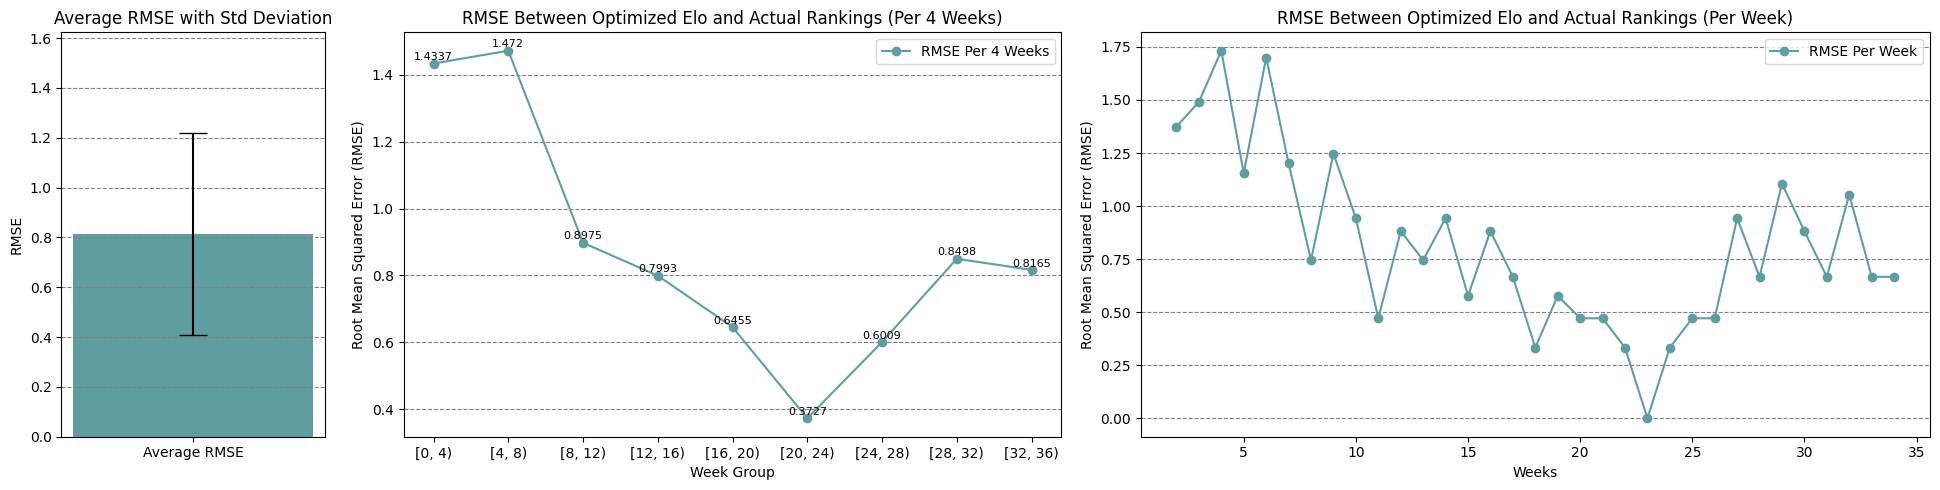

In [ ]:

def compare_rankings(elo_ratings_df, weekly_rankings):
    """
    Compare Elo rankings with actual weekly rankings and calculate the rank difference.
    
    elo_ratings_df: DataFrame with Elo ratings and ranks by week.
    weekly_rankings: DataFrame with actual rankings by week.
    """
    comparison_df = pd.merge(elo_ratings_df[['Team', 'Rank', 'Week']], 
                             weekly_rankings[['Team', 'Wk', 'rank']], 
                             left_on=['Team', 'Week'], right_on=['Team', 'Wk'], 
                             suffixes=('_elo', '_actual'))
    
    comparison_df['rank_diff'] = abs(comparison_df['Rank'] - comparison_df['rank'])

    mae = comparison_df.groupby('Week')['rank_diff'].apply(lambda x: np.sqrt(np.mean(x ** 2)))
    #print(comparison_df.head(50))
    
    return comparison_df


comparison_df = compare_rankings(weekly_optimized_elo_ratings, weekly_rankings)

rmse_per_week = comparison_df.groupby('Wk')['rank_diff'].apply(lambda x: np.sqrt(np.mean(x ** 2)))
bins = np.arange(0, comparison_df['Wk'].max() + 4, 4)
comparison_df['Week_Group'] = pd.cut(comparison_df['Wk'], bins=bins, right=False)
rmse_per_four_weeks = comparison_df.groupby('Week_Group')['rank_diff'].apply(lambda x: np.sqrt(np.mean(x ** 2)))
avg_rmse = rmse_per_week.mean()
print(avg_rmse)
std_rmse = rmse_per_week.std()
print(std_rmse)

fig, ax = plt.subplots(1, 3, figsize=(19.5, 5), gridspec_kw={'width_ratios': [1, 2.5, 3]})
ax[0].bar(['Average RMSE'], [avg_rmse], yerr=[std_rmse], capsize=10, color='cadetblue')
ax[0].set_title('Average RMSE with Std Deviation')
ax[0].set_ylabel('RMSE')
ax[0].set_ylim(0, avg_rmse + 2 * std_rmse)  # Adjust the y-limit to fit the error bars
ax[0].grid(True, which='both', axis='y', linestyle='--', color='gray')
rmse_per_four_weeks.index = rmse_per_four_weeks.index.astype(str)
ax[1].plot(rmse_per_four_weeks.index, rmse_per_four_weeks.values, marker='o', color='cadetblue', label='RMSE Per 4 Weeks')
ax[1].set_title('RMSE Between Optimized Elo and Actual Rankings (Per 4 Weeks)')
ax[1].set_xlabel('Week Group')
ax[1].set_ylabel('Root Mean Squared Error (RMSE)')
ax[1].grid(True, which='both', axis='y', linestyle='--', color='gray')
ax[1].legend()
for i, v in enumerate(rmse_per_four_weeks.values):
    ax[1].text(i, v + 0.01, f'{round(v, 4)}', ha='center', fontsize=8)
ax[2].plot(rmse_per_week.index, rmse_per_week.values, marker='o', color='cadetblue', label='RMSE Per Week')
ax[2].set_title('RMSE Between Optimized Elo and Actual Rankings (Per Week)')
ax[2].set_xlabel('Weeks')
ax[2].set_ylabel('Root Mean Squared Error (RMSE)')
ax[2].grid(True, which='both', axis='y', linestyle='--', color='gray')
ax[2].legend()

plt.tight_layout()
plt.show()


#### Validation results 

The figure above indicates that the optimized ELO model has an average RMSE of 0.8142471407500128 and an average standard deviation of 0.40 in both directions for weekly rank predictions. The second graph highlights the model's performance in predicting rankings every four weeks, showing that its accuracy was highest around the middle of the season. However, during the initial and final weeks, the model's performance was significantly above average. Furthermore, the instability of the model's predictions is particularly evident in the second and third graphs, where large fluctuations are observed in the early and late stages of the season. Despite this, the model performs well in real-world soccer league scenarios for weekly rank prediction, although it struggles with accuracy in the beginning and end of the season. This could be due to various factors, including the increased unpredictability as teams become more aggressive in their quest for victory.

### Data Analysis 

From this section, different analysis are conducted, which helps to identify where the model made wrong predictions. How to identify potential factors which are not captured in K and S values, that has potential to further improve the optimized ELO model?

#### Biggest Prediction Errors

The following section highlights the matches with the largest prediction errors. The accompanying histogram illustrates the distribution of prediction errors across matches.

#### Main Findings
1. Hannover 96 vs Dortmund: The most significant prediction error occurred in this match, where the league's bottom-ranked team defeated the second-ranked team. This outcome could be one of the most surprising upsets. In reality, during the last few days of the league, teams may adjust their effort levels due to player fatigue, or because the match result has little to no effect on the final rankings, leading to deviations from expected performance.

2. The model produced 0.45 prediction errors across 50 matches.

##### Limitations of the Optimized ELO Model for Weekly Prediction
-: The elo rating scale might be a possible area for further time consuming analysis as penalizing with high rating points in matches with predicition error might be crucial reason for low model performance in certain weeks. There are more than 50 matches where the prediction errors are 0.45.


#### Analysis Next Steps
Explore the relationship between prediction error and specific weeks: Is there a noticeable pattern in prediction errors occurring more frequently at the beginning, middle, or end of the season?

Since the ELO ratings determine team rankings, conducting a trend analysis to understand the relationship between significant ELO rating changes and various stages of the season (beginning, mid, and end) could provide insights into model performance fluctuations.


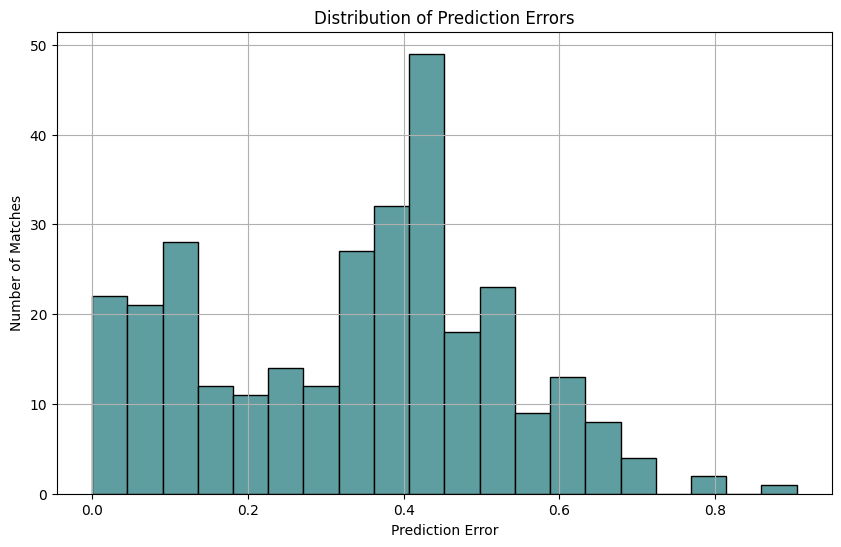

In [ ]:

matches_with_elo = pd.merge(
    match_df, 
    weekly_optimized_elo_ratings[['Team', 'Week', 'Elo']],  # Home team Elo
    left_on=['Home', 'Wk'], 
    right_on=['Team', 'Week'],
    suffixes=('_home', '_away')
)

matches_with_elo = pd.merge(
    matches_with_elo, 
    weekly_optimized_elo_ratings[['Team', 'Week', 'Elo']],  # Away team Elo
    left_on=['Away', 'Wk'], 
    right_on=['Team', 'Week'],
    suffixes=('_home', '_away')
)
matches_with_elo = matches_with_elo.rename(columns={'Elo_home': 'Elo_Home', 'Elo_away': 'Elo_Away'})
matches_with_elo['expected_home_win'] = matches_with_elo.apply(
    lambda x: expected_outcome_elo(x['Elo_Home'], x['Elo_Away']), axis=1
)

matches_with_elo['actual_home_win'] = matches_with_elo.apply(
    lambda x: 1 if x['Home Score'] > x['Away Score'] else (0.5 if x['Home Score'] == x['Away Score'] else 0),
    axis=1
)

matches_with_elo['prediction_error'] = abs(matches_with_elo['expected_home_win'] - matches_with_elo['actual_home_win'])
unpredictable_matches = matches_with_elo.sort_values(by='prediction_error', ascending=False)

up = unpredictable_matches[['Date', 'Home', 'Away', 'Home Score', 'Away Score', 'expected_home_win', 'actual_home_win', 'prediction_error']].head(20)
plt.figure(figsize=(10, 6))
plt.hist(matches_with_elo['prediction_error'], bins=20, color='cadetblue', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Number of Matches')
plt.grid(True)
plt.show()




#### Relationship between Average ELO change by Rank & Week

In this task, the aim is to first calculate an average of elo change based on 5 weeks. Then explore, if there are certain weeks where the elo is changing rapidly for teams. Further, checking if there is certain team or rank teams if their elo rating chnage in positive or negative in general. 

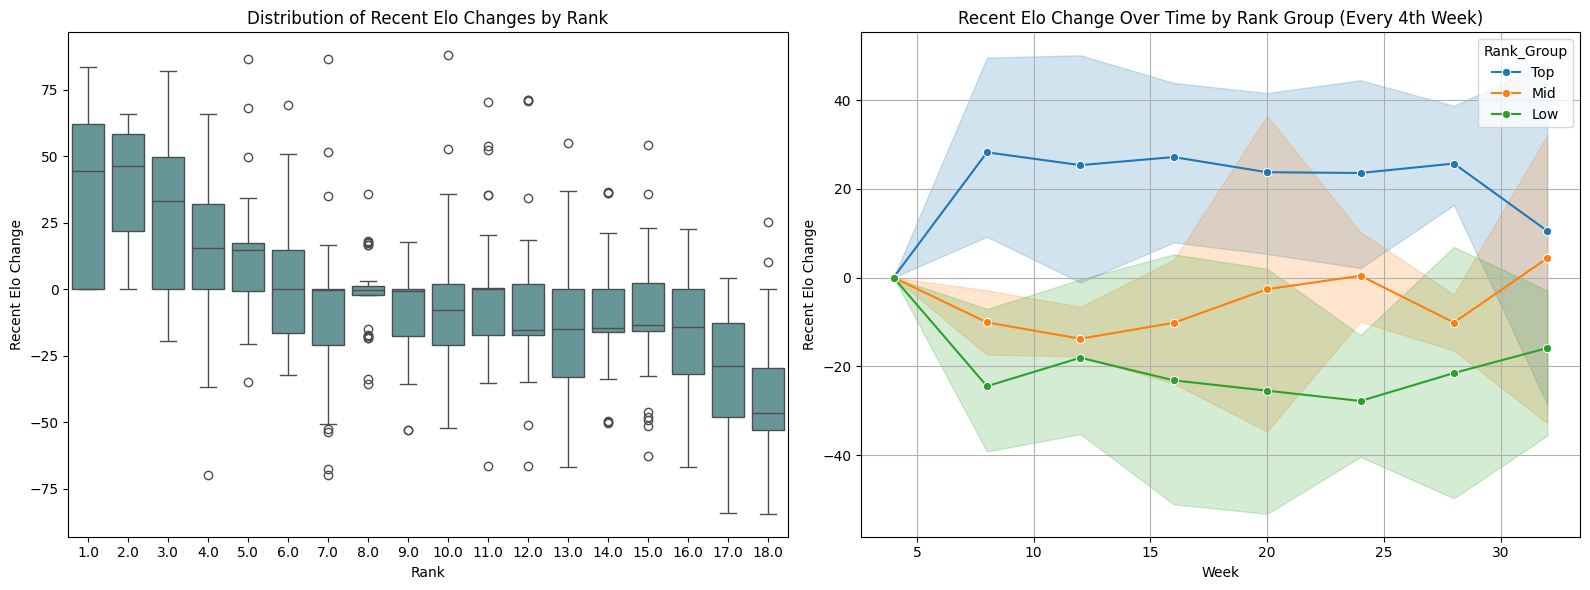

In [ ]:
weekly_optimized_elo_ratings['recent_elo_change'] = weekly_optimized_elo_ratings.groupby('Team')['Elo'].diff(5).fillna(0)
weekly_optimized_elo_ratings
avg_elo_change_by_rank = weekly_optimized_elo_ratings.groupby('Rank')['recent_elo_change'].mean()
avg_elo_change_by_week = weekly_optimized_elo_ratings.groupby('Week')['recent_elo_change'].mean()

elo_df = weekly_optimized_elo_ratings
elo_df['momentum'] = elo_df.groupby('Team')['recent_elo_change'].rolling(window=3).mean().reset_index(0, drop=True)
mid_table_teams = elo_df[(elo_df['Rank'] >= 5) & (elo_df['Rank'] <= 15)]
bottom_teams = elo_df[elo_df['Rank'] >= 16]
elo_df['Rank_Group'] = pd.cut(elo_df['Rank'], bins=[0, 7, 12, 18], labels=['Top', 'Mid', 'Low'])

elo_df_filtered = elo_df[elo_df['Week'] % 4 == 0]

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x='Rank', y='recent_elo_change', data=elo_df, ax=ax[0],color = 'cadetblue')
ax[0].set_title("Distribution of Recent Elo Changes by Rank")
ax[0].set_xlabel("Rank")
ax[0].set_ylabel("Recent Elo Change")
sns.lineplot(x='Week', y='recent_elo_change', hue='Rank_Group', data=elo_df_filtered, marker='o', ax=ax[1])
ax[1].set_title("Recent Elo Change Over Time by Rank Group (Every 4th Week)")
ax[1].set_xlabel("Week")
ax[1].set_ylabel("Recent Elo Change")
ax[1].grid(True)

plt.tight_layout()
plt.show()

##### Discussion 

Based on the first graph in the above code section critical findings are as follows:

1. **The high rank teams has higher difference in their Elo changes behaviour. On the other hand side, the teams from 6th rank to 15th elo change behaviour is more similar indicated a tight competition or not many unexpected win or loss. This indicates that a goal profile of the teams can be useful feature in rank decisions as the elo change behaviour is more similar**.

2. **Based on the first results of elo change by rank. The teams are divided in three groups. The Top group consists teams below 5th rank, mid group consists teams with rank between 6th to 15th and last group above 15th rank. The second graph, showcase top three groups of teams elo change per week. From the second graph, from 10th week to 15th week the mid and lower group elo changes are similar and in negative, and the same trend reflect between 25th to 30th week**. 

##### Further course

-: An experiment of introducing a scale factor based on season stage can ve tested with value value from 0 to 1 which will make K factor dynamic. 

-: An experiment of introducing a scale factor based on goal difference where in the earl season a higher goal difference win advantage is given, lesser for mid season and least for last phase of the season make K factor dynamic.

#### Experiment 2 

### Trial 1

In this experiment a scale factor based on season stage introduced. Try and error approach was used to try different scale. The value of 0.22 gave the best predicition result. 

In [ ]:


def scale_k_by_season_stage(K, current_week, total_weeks):
    progress_ratio = current_week / total_weeks
    return K * (1 - (progress_ratio ** 2) * 0.22)

def apply_weekly_elo_to_season(matches, K=35, s=1835.164463871772, initial_rating=100):
    """
    Elo rating system to a season's matches with season stage scaling and return weekly Elo ratings.
    """
    teams = pd.concat([matches['Home'], matches['Away']]).unique()
    elo_ratings = {team: initial_rating for team in teams}
    
    weekly_elo_ratings = pd.DataFrame()

    total_weeks = matches['Wk'].max()
    
    for week in range(1, total_weeks + 1):
        weekly_matches = matches[matches['Wk'] == week]
        
        for index, row in weekly_matches.iterrows():
            home_team = row['Home']
            away_team = row['Away']
            home_goals = row['Home Score']
            away_goals = row['Away Score']

            # Determine match result
            if home_goals > away_goals:
                S_home, S_away = 1, 0
            elif home_goals == away_goals:
                S_home, S_away = 0.5, 0.5
            else:
                S_home, S_away = 0, 1

            R_home = elo_ratings[home_team]
            R_away = elo_ratings[away_team]

            E_home = expected_outcome_elo(R_home, R_away, s)
            E_away = expected_outcome_elo(R_away, R_home, s)
            dynamic_K_home = scale_k_by_season_stage(K, week, total_weeks)
            dynamic_K_away = scale_k_by_season_stage(K, week, total_weeks)
            elo_ratings[home_team] = update_elo_rating(R_home, S_home, E_home, dynamic_K_home)
            elo_ratings[away_team] = update_elo_rating(R_away, S_away, E_away, dynamic_K_away)

        weekly_ratings = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo'])
        weekly_ratings['Week'] = week
        weekly_ratings['Rank'] = weekly_ratings['Elo'].rank(ascending=False, method='min')

        weekly_elo_ratings = pd.concat([weekly_elo_ratings, weekly_ratings], ignore_index=True)

    return weekly_elo_ratings

weekly_elo_ratings_season = apply_weekly_elo_to_season(match_df, K=35, s=1835.164463871772, initial_rating=100)
print(weekly_elo_ratings_season)


              Team         Elo  Week  Rank
0    Bayern Munich  107.498573     1   1.0
1         Augsburg   92.501427     1  11.0
2       Leverkusen  107.498573     1   1.0
3     Darmstadt 98  100.000000     1   9.0
4         Mainz 05   92.501427     1  11.0
..             ...         ...   ...   ...
607     Hoffenheim   73.988444    34  14.0
608           Koln   93.790153    34   8.0
609   Hamburger SV   77.891860    34  10.0
610  Ingolstadt 04   77.880504    34  11.0
611       Gladbach  123.722105    34   4.0

[612 rows x 4 columns]


#### Experiment 2 

### Trial 2

This experiment introduced a scale factor based on the mid-tier draw. This means the match ends in the draw for the teams with a rank higher than 5th and below 12th have a 20% higher K factor based on the ELO change analysis. The results didn’t improve further with this scale. 


In [ ]:

def scale_k_by_season_stage(K, current_week, total_weeks):
    """
    Scale K based on the progress of the season.
    K is larger early in the season and decreases as the season progresses.
    """
    progress_ratio = current_week / total_weeks
    return K * (1 - (progress_ratio ** 5) * 0.23)  # Non-linear season scaling

def scale_k_for_mid_tier_draw(K, home_rank, away_rank, S_home, S_away):
    """
    Dynamically scale K if the match ends in a draw and involves mid-tier teams.
    A "mid-tier" team is defined as being ranked between 5 and 12.
    """
    if 5 <= home_rank <= 14 or 5 <= away_rank <= 14:
        if S_home == 0.5 and S_away == 0.5: #Draw
            return K * 1.4  # Increase K by 20% for mid-tier teams in draws
    return K 

def apply_weekly_elo_to_season_with_scaling(matches, K=34, s=2984.65393957448, initial_rating=100):
    """
    Apply Elo rating system to a season's matches with dynamic K adjustment for mid-tier teams in draws
    and season stage scaling.
    """
    teams = pd.concat([matches['Home'], matches['Away']]).unique()
    elo_ratings = {team: initial_rating for team in teams}
    
    weekly_elo_ratings = pd.DataFrame()

    total_weeks = matches['Wk'].max() 
    
    for week in range(1, total_weeks + 1):
        weekly_matches = matches[matches['Wk'] == week]
        
        for index, row in weekly_matches.iterrows():
            home_team = row['Home']
            away_team = row['Away']
            home_goals = row['Home Score']
            away_goals = row['Away Score']

            if home_goals > away_goals:
                S_home, S_away = 1, 0
            elif home_goals == away_goals:
                S_home, S_away = 0.5, 0.5
            else:
                S_home, S_away = 0, 1

            R_home = elo_ratings[home_team]
            R_away = elo_ratings[away_team]
            E_home = expected_outcome_elo(R_home, R_away, s)
            E_away = expected_outcome_elo(R_away, R_home, s)
            teams_sorted = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo']).sort_values(by='Elo', ascending=False)
            teams_sorted['Rank'] = teams_sorted['Elo'].rank(ascending=False, method='min')
            home_rank = teams_sorted.loc[teams_sorted['Team'] == home_team, 'Rank'].values[0]
            away_rank = teams_sorted.loc[teams_sorted['Team'] == away_team, 'Rank'].values[0]
            dynamic_K = scale_k_by_season_stage(K, week, total_weeks)
            dynamic_K = scale_k_for_mid_tier_draw(dynamic_K, home_rank, away_rank, S_home, S_away)
            elo_ratings[home_team] = update_elo_rating(R_home, S_home, E_home, dynamic_K)
            elo_ratings[away_team] = update_elo_rating(R_away, S_away, E_away, dynamic_K)
        weekly_ratings = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo'])
        weekly_ratings['Week'] = week
        weekly_ratings['Rank'] = weekly_ratings['Elo'].rank(ascending=False, method='min')
        weekly_elo_ratings = pd.concat([weekly_elo_ratings, weekly_ratings], ignore_index=True)

    return weekly_elo_ratings

weekly_elo_ratings_mid_tier = apply_weekly_elo_to_season_with_scaling(match_df, K=35, s=1835.164463871772, initial_rating=100)
print(weekly_elo_ratings_mid_tier)


              Team         Elo  Week  Rank
0    Bayern Munich  117.500000     1   1.0
1         Augsburg   82.500000     1  11.0
2       Leverkusen  117.500000     1   1.0
3     Darmstadt 98  100.000000     1   9.0
4         Mainz 05   82.500000     1  11.0
..             ...         ...   ...   ...
607     Hoffenheim   25.352454    34  14.0
608           Koln   81.734129    34   8.0
609   Hamburger SV   39.882799    34  11.0
610  Ingolstadt 04   43.049919    34  10.0
611       Gladbach  159.477310    34   4.0

[612 rows x 4 columns]


#### Experiment 2 

### Trial 3

In this experiment, a scale factor based on goal difference was introduced. This means that a match with a higher goal difference results in more K factor than lower goal differences. The results improved the performance of the model. Hence, broadening this scale was experimented with in the following trials. 

In [ ]:

def scale_k_for_mid_tier_draw(K, home_rank, away_rank, S_home, S_away):
    """
    Dynamically scale K if the match ends in a draw and involves mid-tier teams.
    A "mid-tier" team is defined as being ranked between 5 and 12.
    """
    if 5 <= home_rank <= 14 or 5 <= away_rank <= 14:
        if S_home == 0.5 and S_away == 0.5:  # Match ended in a draw
            return K * 1.6  # Increase K by 40% for mid-tier teams in draws
    return K  # Return unmodified K otherwise

def scale_k_by_goal_difference(K, goal_difference):
    """
    Scale the K factor based on the goal difference.
    Larger goal differences result in a larger K factor, while smaller differences moderate K.
    """
    return K * (1 + (goal_difference ** 0.6) / 4)

def apply_weekly_elo_to_season_with_scaling_and_goal_diff(matches, K=34, s=2984.65393957448, initial_rating=100):
    """
    Apply Elo rating system to a season's matches with dynamic K adjustment for mid-tier teams in draws,
    season stage scaling, and goal difference scaling.
    """
    teams = pd.concat([matches['Home'], matches['Away']]).unique()
    elo_ratings = {team: initial_rating for team in teams}
    
    weekly_elo_ratings = pd.DataFrame()

    total_weeks = matches['Wk'].max()
    
    for week in range(1, total_weeks + 1):
        weekly_matches = matches[matches['Wk'] == week]
        
        for index, row in weekly_matches.iterrows():
            home_team = row['Home']
            away_team = row['Away']
            home_goals = row['Home Score']
            away_goals = row['Away Score']

            if home_goals > away_goals:
                S_home, S_away = 1, 0
            elif home_goals == away_goals:
                S_home, S_away = 0.5, 0.5
            else:
                S_home, S_away = 0, 1

            goal_difference = abs(home_goals - away_goals)
            R_home = elo_ratings[home_team]
            R_away = elo_ratings[away_team]
            E_home = expected_outcome_elo(R_home, R_away, s)
            E_away = expected_outcome_elo(R_away, R_home, s)

            teams_sorted = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo']).sort_values(by='Elo', ascending=False)
            teams_sorted['Rank'] = teams_sorted['Elo'].rank(ascending=False, method='min')
            home_rank = teams_sorted.loc[teams_sorted['Team'] == home_team, 'Rank'].values[0]
            away_rank = teams_sorted.loc[teams_sorted['Team'] == away_team, 'Rank'].values[0]
            dynamic_K = scale_k_by_season_stage(K, week, total_weeks)
            dynamic_K = scale_k_for_mid_tier_draw(dynamic_K, home_rank, away_rank, S_home, S_away)
            dynamic_K = scale_k_by_goal_difference(dynamic_K, goal_difference)
            elo_ratings[home_team] = update_elo_rating(R_home, S_home, E_home, dynamic_K)
            elo_ratings[away_team] = update_elo_rating(R_away, S_away, E_away, dynamic_K)

        weekly_ratings = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo'])
        weekly_ratings['Week'] = week
        weekly_ratings['Rank'] = weekly_ratings['Elo'].rank(ascending=False, method='min')
        weekly_elo_ratings = pd.concat([weekly_elo_ratings, weekly_ratings], ignore_index=True)

    return weekly_elo_ratings

weekly_elo_ratings = apply_weekly_elo_to_season_with_scaling_and_goal_diff(match_df, K=35, s=1835.164463871772, initial_rating=100)
print(weekly_elo_ratings)


              Team         Elo  Week  Rank
0    Bayern Munich  128.991059     1   1.0
1         Augsburg   78.125000     1  11.0
2       Leverkusen  121.875000     1   5.0
3     Darmstadt 98  100.000000     1   9.0
4         Mainz 05   78.125000     1  11.0
..             ...         ...   ...   ...
607     Hoffenheim   -0.494560    34  14.0
608           Koln   71.667762    34   8.0
609   Hamburger SV   25.792513    34  10.0
610  Ingolstadt 04   24.246710    34  11.0
611       Gladbach  194.429527    34   4.0

[612 rows x 4 columns]


#### Experiment 2 

### Trial 4

In this experiment, a scale factor based on goal difference was extended by adding a higher goal difference before 8th week to 12th week has high K factor, in the end of experiment 12th week found with the best results. Above 12th week a lower K factor for high goal difference.

In [ ]:


def scale_k_for_mid_tier_draw(K, home_rank, away_rank, S_home, S_away):
    """
    Dynamically scale K if the match ends in a draw and involves mid-tier teams.
    A "mid-tier" team is defined as being ranked between 5 and 12.
    """
    if 5 <= home_rank <= 14 or 5 <= away_rank <= 14:
        if S_home == 0.5 and S_away == 0.5:  # Match ended in a draw
            return K * 1.4  # Increase K by 40% for mid-tier teams in draws
    return K  # Return unmodified K otherwise

def scale_k_by_goal_difference(K, goal_difference, current_week):
    """
    Scale the K factor based on the goal difference with more weight in the first 12 weeks.
    Larger goal differences result in a larger K factor, while smaller differences moderate K.
    """
    if current_week <= 12:
        # Apply more aggressive scaling in the first 12 weeks
        return K * (1 + (goal_difference ** 0.53) / 2)  # Larger scaling in early weeks
    else:
        # Apply normal scaling beyond week 12
        return K * (1 + (goal_difference ** 0.8) / 4)

def apply_weekly_elo_to_season_with_dynamic_goal_diff(matches, K=34, s=2984.65393957448, initial_rating=100):
    """
    Apply Elo rating system to a season's matches with dynamic K adjustment for mid-tier teams in draws,
    season stage scaling, and dynamic goal difference scaling.
    """
    teams = pd.concat([matches['Home'], matches['Away']]).unique()
    elo_ratings = {team: initial_rating for team in teams}
    
    weekly_elo_ratings = pd.DataFrame()

    total_weeks = matches['Wk'].max()
    
    for week in range(1, total_weeks + 1):
        weekly_matches = matches[matches['Wk'] == week]
        
        for index, row in weekly_matches.iterrows():
            home_team = row['Home']
            away_team = row['Away']
            home_goals = row['Home Score']
            away_goals = row['Away Score']
            if home_goals > away_goals:
                S_home, S_away = 1, 0
            elif home_goals == away_goals:
                S_home, S_away = 0.5, 0.5
            else:
                S_home, S_away = 0, 1

            goal_difference = abs(home_goals - away_goals)
            R_home = elo_ratings[home_team]
            R_away = elo_ratings[away_team]
            E_home = expected_outcome_elo(R_home, R_away, s)
            E_away = expected_outcome_elo(R_away, R_home, s)
            teams_sorted = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo']).sort_values(by='Elo', ascending=False)
            teams_sorted['Rank'] = teams_sorted['Elo'].rank(ascending=False, method='min')
            home_rank = teams_sorted.loc[teams_sorted['Team'] == home_team, 'Rank'].values[0]
            away_rank = teams_sorted.loc[teams_sorted['Team'] == away_team, 'Rank'].values[0]
            dynamic_K = scale_k_by_season_stage(K, week, total_weeks)
            dynamic_K = scale_k_for_mid_tier_draw(dynamic_K, home_rank, away_rank, S_home, S_away)
            dynamic_K = scale_k_by_goal_difference(dynamic_K, goal_difference, week)
            elo_ratings[home_team] = update_elo_rating(R_home, S_home, E_home, dynamic_K)
            elo_ratings[away_team] = update_elo_rating(R_away, S_away, E_away, dynamic_K)

        weekly_ratings = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo'])
        weekly_ratings['Week'] = week
        weekly_ratings['Rank'] = weekly_ratings['Elo'].rank(ascending=False, method='min')
        weekly_elo_ratings = pd.concat([weekly_elo_ratings, weekly_ratings], ignore_index=True)

    return weekly_elo_ratings

weekly_elo_ratings = apply_weekly_elo_to_season_with_dynamic_goal_diff(match_df, K=35, s=1835.164463871772, initial_rating=100)
print(weekly_elo_ratings)


              Team         Elo  Week  Rank
0    Bayern Munich  138.033461     1   1.0
1         Augsburg   73.750000     1  11.0
2       Leverkusen  126.250000     1   5.0
3     Darmstadt 98  100.000000     1   9.0
4         Mainz 05   73.750000     1  11.0
..             ...         ...   ...   ...
607     Hoffenheim  -23.435259    34  15.0
608           Koln   70.077149    34   9.0
609   Hamburger SV   20.710226    34  11.0
610  Ingolstadt 04   21.022638    34  10.0
611       Gladbach  211.272119    34   4.0

[612 rows x 4 columns]


#### Final Optimised ELO rank model

Final Version of Optmized K and S values with scaling of Season Stage by number of weeks, Mid tier teams draw stretegy scaling, and Scaling of goal difference in less than 8 weeks, 12 weeks and above 12 weeks was found with the best results. 

In [15]:


def scale_k_for_mid_tier_draw(K, home_rank, away_rank, S_home, S_away):
    """
    Dynamically scale K if the match ends in a draw and involves mid-tier teams.
    A "mid-tier" team is defined as being ranked between 5 and 12.
    """
    if 5 <= home_rank <= 14 or 5 <= away_rank <= 14:
        if S_home == 0.5 and S_away == 0.5:  # Match ended in a draw
            return K * 1.4  # Increase K by 40% for mid-tier teams in draws
    return K  # Return unmodified K otherwise

def scale_k_by_goal_difference(K, goal_difference, current_week):
    """
    Scale the K factor based on the goal difference with different scaling for different stages of the season.
    Larger goal differences result in a larger K factor, while smaller differences moderate K.
    """
    if current_week <= 8:
        # Highest scaling in the first 6 weeks
        return K * (1 + (goal_difference ** 0.4) / 2) 
    elif current_week <= 12:
        # Moderate scaling from week 7 to 12
        return K * (1 + (goal_difference ** 0.57) / 2)
    else:
        # Normal scaling beyond week 12
        return K * (1 + (goal_difference ** 0.8) / 4) 
def apply_weekly_elo_to_season_with_three_phase_goal_diff(matches, K=34, s=2984.65393957448, initial_rating=100):
    """
    Apply Elo rating system to a season's matches with dynamic K adjustment for mid-tier teams in draws,
    season stage scaling, and three-phase dynamic goal difference scaling.
    """
    teams = pd.concat([matches['Home'], matches['Away']]).unique()
    elo_ratings = {team: initial_rating for team in teams}
    weekly_elo_ratings = pd.DataFrame()
    total_weeks = matches['Wk'].max()
    
    for week in range(1, total_weeks + 1):
        weekly_matches = matches[matches['Wk'] == week]
        
        for index, row in weekly_matches.iterrows():
            home_team = row['Home']
            away_team = row['Away']
            home_goals = row['Home Score']
            away_goals = row['Away Score']

            if home_goals > away_goals:
                S_home, S_away = 1, 0
            elif home_goals == away_goals:
                S_home, S_away = 0.5, 0.5
            else:
                S_home, S_away = 0, 1

            goal_difference = abs(home_goals - away_goals)
            R_home = elo_ratings[home_team]
            R_away = elo_ratings[away_team]
            E_home = expected_outcome_elo(R_home, R_away, s)
            E_away = expected_outcome_elo(R_away, R_home, s)
            teams_sorted = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo']).sort_values(by='Elo', ascending=False)
            teams_sorted['Rank'] = teams_sorted['Elo'].rank(ascending=False, method='min')
            home_rank = teams_sorted.loc[teams_sorted['Team'] == home_team, 'Rank'].values[0]
            away_rank = teams_sorted.loc[teams_sorted['Team'] == away_team, 'Rank'].values[0]
            dynamic_K = scale_k_by_season_stage(K, week, total_weeks)
            dynamic_K = scale_k_for_mid_tier_draw(dynamic_K, home_rank, away_rank, S_home, S_away)
            dynamic_K = scale_k_by_goal_difference(dynamic_K, goal_difference, week)
            elo_ratings[home_team] = update_elo_rating(R_home, S_home, E_home, dynamic_K)
            elo_ratings[away_team] = update_elo_rating(R_away, S_away, E_away, dynamic_K)
        weekly_ratings = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo'])
        weekly_ratings['Week'] = week
        weekly_ratings['Rank'] = weekly_ratings['Elo'].rank(ascending=False, method='min')
        weekly_elo_ratings = pd.concat([weekly_elo_ratings, weekly_ratings], ignore_index=True)

    return weekly_elo_ratings

weekly_final_elo_ratings = apply_weekly_elo_to_season_with_three_phase_goal_diff(match_df, K=35, s=1835.164463871772, initial_rating=100)
print(weekly_final_elo_ratings)


              Team         Elo  Week  Rank
0    Bayern Munich  134.156972     1   1.0
1         Augsburg   73.750000     1  11.0
2       Leverkusen  126.250000     1   5.0
3     Darmstadt 98  100.000000     1   9.0
4         Mainz 05   73.750000     1  11.0
..             ...         ...   ...   ...
607     Hoffenheim  -23.042917    34  15.0
608           Koln   71.483061    34   9.0
609   Hamburger SV   23.244674    34  10.0
610  Ingolstadt 04   22.117735    34  11.0
611       Gladbach  213.572808    34   4.0

[612 rows x 4 columns]


0.7085466624430702
0.28501098456422486


/var/folders/63/0b8dx7sj4ws695cdyf037v3c0000gp/T/ipykernel_888/2252991784.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rmse_per_four_weeks_1 = comparison_df.groupby('Week_Group')['rank_diff'].apply(lambda x: np.sqrt(np.mean(x ** 2)))


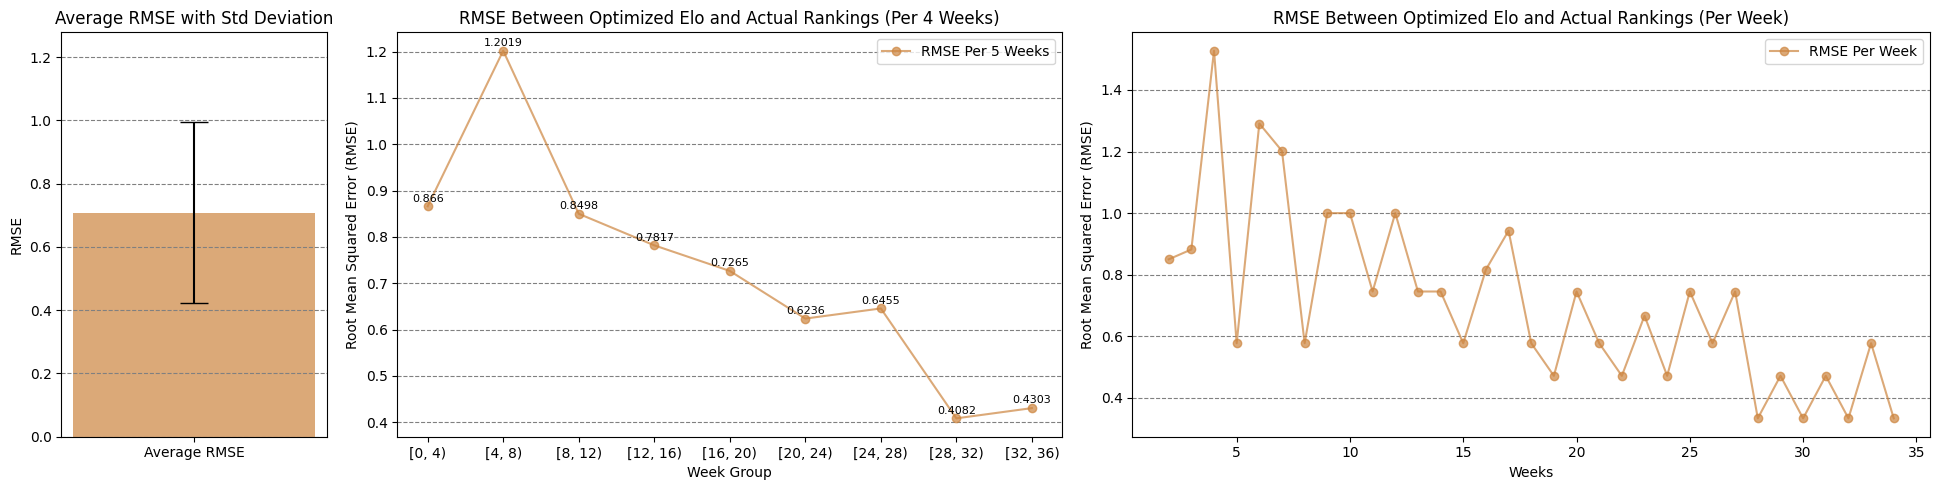

In [12]:

def compare_rankings(elo_ratings_df, weekly_rankings):
    """
    Compare Elo rankings with actual weekly rankings and calculate the rank difference.
    
    elo_ratings_df: DataFrame with Elo ratings and ranks by week.
    weekly_rankings: DataFrame with actual rankings by week.
    """
    comparison_df = pd.merge(elo_ratings_df[['Team', 'Rank', 'Week']], 
                             weekly_rankings[['Team', 'Wk', 'rank']], 
                             left_on=['Team', 'Week'], right_on=['Team', 'Wk'], 
                             suffixes=('_elo', '_actual'))
    
    # Calculate rank difference
    comparison_df['rank_diff'] = abs(comparison_df['Rank'] - comparison_df['rank'])

    mae = comparison_df.groupby('Week')['rank_diff'].apply(lambda x: np.sqrt(np.mean(x ** 2)))
    
    # Print the first 50 rows of the comparison DataFrame for debugging
    #print(comparison_df.head(50))
    
    #print(f"Mean Absolute Error between Elo ranks and actual ranks by week: {mae}")
    
    return comparison_df


comparison_df = compare_rankings(weekly_final_elo_ratings, weekly_rankings)
rmse_per_week_1 = comparison_df.groupby('Wk')['rank_diff'].apply(lambda x: np.sqrt(np.mean(x ** 2)))
bins = np.arange(0, comparison_df['Wk'].max() + 4, 4)
comparison_df['Week_Group'] = pd.cut(comparison_df['Wk'], bins=bins, right=False)
avg_rmse = rmse_per_week_1.mean()
print(avg_rmse)
std_rmse = rmse_per_week_1.std()
print(std_rmse)
fig, ax = plt.subplots(1, 3, figsize=(19.5, 5), gridspec_kw={'width_ratios': [1, 2.5, 3]})
ax[0].bar(['Average RMSE'], [avg_rmse], yerr=[std_rmse], capsize=10, color='peru', alpha = 0.7)
ax[0].set_title('Average RMSE with Std Deviation')
ax[0].set_ylabel('RMSE')
ax[0].set_ylim(0, avg_rmse + 2 * std_rmse)  # Adjust the y-limit to fit the error bars
ax[0].grid(True, which='both', axis='y', linestyle='--', color='gray')
rmse_per_four_weeks_1 = comparison_df.groupby('Week_Group')['rank_diff'].apply(lambda x: np.sqrt(np.mean(x ** 2)))
rmse_per_four_weeks_1.index = rmse_per_four_weeks_1.index.astype(str)
ax[1].plot(rmse_per_four_weeks_1.index, rmse_per_four_weeks_1.values, marker='o', color='peru', alpha = 0.7, label='RMSE Per 5 Weeks')
ax[1].set_title('RMSE Between Optimized Elo and Actual Rankings (Per 4 Weeks)')
ax[1].set_xlabel('Week Group')
ax[1].set_ylabel('Root Mean Squared Error (RMSE)')
ax[1].grid(True, which='both', axis='y', linestyle='--', color='gray')
ax[1].legend()
for i, v in enumerate(rmse_per_four_weeks_1.values):
    ax[1].text(i, v + 0.01, f'{round(v, 4)}', ha='center', fontsize=8)
ax[2].plot(rmse_per_week_1.index, rmse_per_week_1.values, marker='o', color='peru', alpha = 0.7, label='RMSE Per Week')
ax[2].set_title('RMSE Between Optimized Elo and Actual Rankings (Per Week)')
ax[2].set_xlabel('Weeks')
ax[2].set_ylabel('Root Mean Squared Error (RMSE)')
ax[2].grid(True, which='both', axis='y', linestyle='--', color='gray')
ax[2].legend()

plt.tight_layout()
plt.show()


### Comparative Analysis of Optimized ELO model & Final ELO model

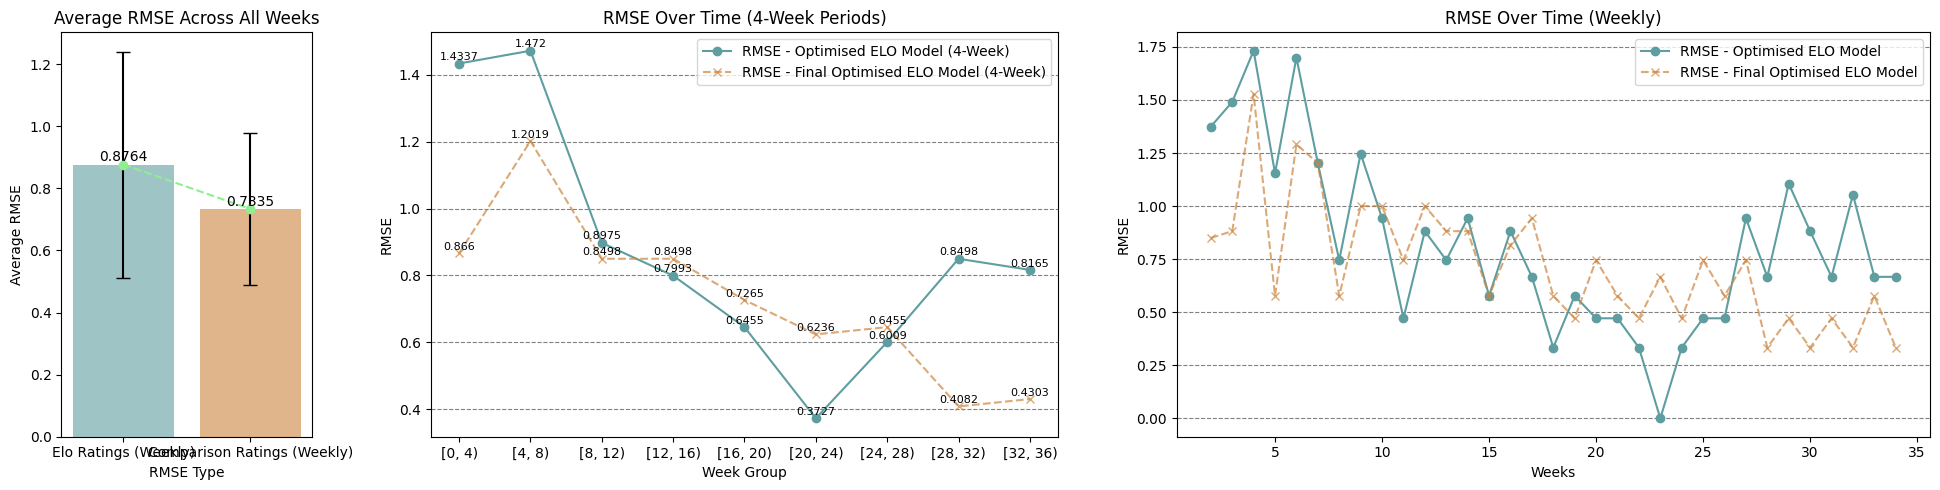

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(19.5, 5), gridspec_kw={'width_ratios': [1, 2.5, 3]})
average_rmse_week_elo = rmse_per_four_weeks.mean()
average_rmse_week_comparison = rmse_per_four_weeks_1.mean()
std_rmse_week_elo = rmse_per_four_weeks.std()
std_rmse_week_comparison = rmse_per_four_weeks_1.std()
average_rmse_week_df = pd.DataFrame({
    'RMSE Type': ['Elo Ratings (Weekly)', 'Comparison Ratings (Weekly)'],
    'Average RMSE': [average_rmse_week_elo, average_rmse_week_comparison],
    'Standard Deviation': [std_rmse_week_elo, std_rmse_week_comparison]
})


ax[0].bar(
    average_rmse_week_df['RMSE Type'],
    average_rmse_week_df['Average RMSE'],
    yerr=average_rmse_week_df['Standard Deviation'],
    capsize=5,
    color=['cadetblue', 'peru'],
    alpha=0.6
)

ax[0].plot([0, 1], [average_rmse_week_elo, average_rmse_week_comparison], color='lightgreen', linestyle='--', marker='o')
ax[0].set_title('Average RMSE Across All Weeks')
ax[0].set_xlabel('RMSE Type')
ax[0].set_ylabel('Average RMSE')

for index, value in enumerate(average_rmse_week_df['Average RMSE']):
    ax[0].text(index, value + 0.01, round(value, 4), ha='center', fontsize=10)

rmse_per_four_weeks.index = rmse_per_four_weeks.index.astype(str)
ax[1].plot(rmse_per_four_weeks.index, rmse_per_four_weeks.values, marker='o', color='cadetblue', label='RMSE - Optimised ELO Model (4-Week)')
ax[1].plot(rmse_per_four_weeks_1.index, rmse_per_four_weeks_1.values, marker='x', linestyle='--', color='peru', alpha = 0.7, label='RMSE - Final Optimised ELO Model (4-Week)')
ax[1].set_title('RMSE Over Time (4-Week Periods)')
ax[1].set_xlabel('Week Group')
ax[1].set_ylabel('RMSE')
ax[1].legend()
ax[1].grid(True, which='both', axis='y', linestyle='--', color='gray')
for i, v in enumerate(rmse_per_four_weeks.values):
    ax[1].text(i, v + 0.01, f'{round(v, 4)}', ha='center', fontsize=8)
for i, v in enumerate(rmse_per_four_weeks_1.values):
    ax[1].text(i, v + 0.01, f'{round(v, 4)}', ha='center', fontsize=8)

ax[2].plot(rmse_per_week.index, rmse_per_week.values, marker='o', color= 'cadetblue', label='RMSE - Optimised ELO Model')
ax[2].plot(rmse_per_week_1.index, rmse_per_week_1.values, marker='x', linestyle='--', color='peru', alpha = 0.7, label='RMSE - Final Optimised ELO Model')
ax[2].set_title('RMSE Over Time (Weekly)')
ax[2].set_xlabel('Weeks')
ax[2].set_ylabel('RMSE')
ax[2].legend()
ax[2].grid(True, which='both', axis='y', linestyle='--', color='gray')
plt.tight_layout()
plt.show()

#### Validation of Final Rank Model Prediction VS Actual Rank of the teams based on weekly prediction

In a comparative analysis between the optimized ELO model and the final optimized ELO model for 3 weekly predictions as weekly predicition consists much instability and noise, **a difference in average RMSE of .14 was found in favor of the final optimized ELO model**. However, the optimized model predictions were more accurate from weeks 20 to 25. On the other hand, the final optimized elo model performed better in the beginning 15 weeks and the last ten weeks of the seasons. The difference between the Optimised and Final ELO models was 0.333. All the results are calculated in the code section below.

#### Limitations and Future course 

While the average RMSE error of 0.7335 for 3 weekly prediction may seem acceptable, the most significant limitation of the Final Optimised ELO model is its instability from 20th week until 25th week. However, with the right adjustments, there is much potential to improve by exploring more feature engineering and combining advance hyperparamter search technique to understand the interaction of dimensions in the space to allow model achieve the ideal balance of stability and sensitivity, providing reassurance about the model's future potential.

In [ ]:
final_elo_rank = weekly_final_elo_ratings[weekly_final_elo_ratings['Week'] == final_week].sort_values(by='Elo', ascending=False)
final_comparison = pd.merge(final_elo_rank[['Team', 'Rank']], final_actual_rank, on='Team', how='left')
final_comparison['Rank_Difference'] = final_comparison['Actual_Rank'] - final_comparison['Rank']
final_comparison = final_comparison.sort_values(by='Rank_Difference', ascending=False)
print("Teams with biggest Elo/Actual Rank difference:")
print(final_comparison)
def calculate_rmse(df):
    df['Squared_Difference'] = df['Rank_Difference'] ** 2
    mean_squared_difference = df['Squared_Difference'].mean()
    rmse = np.sqrt(mean_squared_difference)
    return rmse

rmse_optimised_1 = calculate_rmse(final_comparison)

print(f"RMSE: {rmse_optimised_1}")

print(f"RMSE_Optimised K and S - RMSE_Optimised_K_S_Final_ELO_model: {rmse_optimised-rmse_optimised_1}")

Teams with biggest Elo/Actual Rank difference:
              Team  Rank  Actual_Rank  Rank_Difference
12    Darmstadt 98  13.0           14              1.0
0    Bayern Munich   1.0            1              0.0
1         Dortmund   2.0            2              0.0
16       Stuttgart  17.0           17              0.0
15  Eint Frankfurt  16.0           16              0.0
14      Hoffenheim  15.0           15              0.0
11        Augsburg  12.0           12              0.0
10   Ingolstadt 04  11.0           11              0.0
9     Hamburger SV  10.0           10              0.0
8             Koln   9.0            9              0.0
7        Wolfsburg   8.0            8              0.0
6       Hertha BSC   7.0            7              0.0
5         Mainz 05   6.0            6              0.0
4       Schalke 04   5.0            5              0.0
3         Gladbach   4.0            4              0.0
2       Leverkusen   3.0            3              0.0
17     Hannover 96

#### Validation Analysis 

The section below showcase the results of comparision between Optimised ELO model and Final optimised ELO Model predicition for the last week. The Optimised ELO model predicted 5 wrong predictions and final optimised model predicted 2.

Further, the Heatmaps indicate both weekly predicitions of all teams by both models. 

### Final Team Ranks of both models and actual rank

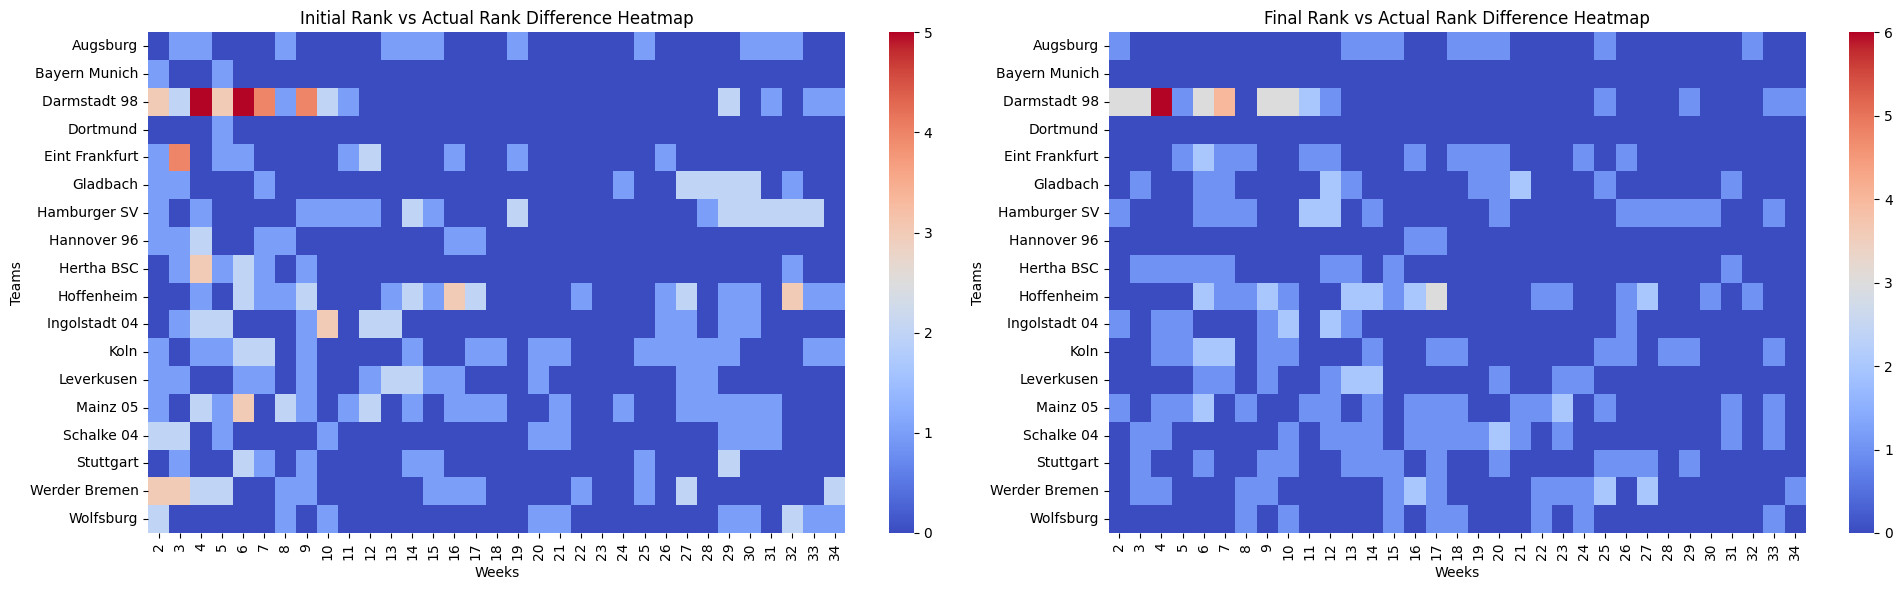

,Team,Rank_initial,Rank_final,Actual_Rank,Initial_vs_Actual_Rank_Difference,Final_vs_Actual_Rank_Difference
17,Werder Bremen,15.0,14.0,13,2.0,1.0
16,Wolfsburg,9.0,8.0,8,1.0,0.0
10,Hertha BSC,7.0,7.0,7,0.0,0.0
15,Hannover 96,18.0,18.0,18,0.0,0.0
14,Leverkusen,3.0,3.0,3,0.0,0.0
13,Gladbach,4.0,4.0,4,0.0,0.0
12,Schalke 04,5.0,5.0,5,0.0,0.0
11,Mainz 05,6.0,6.0,6,0.0,0.0
9,Hamburger SV,10.0,10.0,10,0.0,0.0
8,Ingolstadt 04,11.0,11.0,11,0.0,0.0


In [ ]:

comparison_df = pd.merge(
Initial_comparison[['Team', 'Rank']], final_comparison[['Team', 'Rank', 'Actual_Rank']], 
                         on='Team', suffixes=('_initial', '_final'))

comparison_df['Initial_vs_Actual_Rank_Difference'] = comparison_df['Rank_initial'] - comparison_df['Actual_Rank']
comparison_df['Final_vs_Actual_Rank_Difference'] = comparison_df['Rank_final'] - comparison_df['Actual_Rank']
biggest_differences = comparison_df.sort_values(by='Initial_vs_Actual_Rank_Difference', ascending=False)
def compare_rankings_of_all_model(initial_elo_ratings_df, final_elo_ratings_df, weekly_rankings):
    """
    Compare both initial and final Elo rankings with actual weekly rankings and calculate the rank differences.
    
    initial_elo_ratings_df: DataFrame with initial Elo ratings and ranks by week.
    final_elo_ratings_df: DataFrame with final Elo ratings and ranks by week.
    weekly_rankings: DataFrame with actual rankings by week.
    """
    initial_comparison_df = pd.merge(initial_elo_ratings_df[['Team', 'Rank', 'Week']], 
                                     weekly_rankings[['Team', 'Wk', 'rank']], 
                                     left_on=['Team', 'Week'], right_on=['Team', 'Wk'], 
                                     suffixes=('_elo', '_actual'))

    final_comparison_df = pd.merge(final_elo_ratings_df[['Team', 'Rank', 'Week']], 
                                   initial_comparison_df, 
                                   on=['Team', 'Week'], 
                                   suffixes=('_final', '_initial'))

    final_comparison_df['Initial_vs_Actual_Rank_Difference'] = abs(final_comparison_df['Rank_initial'] - final_comparison_df['rank'])
    final_comparison_df['Final_vs_Actual_Rank_Difference'] = abs(final_comparison_df['Rank_final'] - final_comparison_df['rank'])

    return final_comparison_df


f_comparison_df = compare_rankings_of_all_model(weekly_optimized_elo_ratings, weekly_final_elo_ratings, weekly_rankings)
f_comparison_df['Initial_vs_Actual_Rank_Difference'] = abs(f_comparison_df['Rank_initial'] - f_comparison_df['rank'])

f_comparison_df['Final_vs_Actual_Rank_Difference'] = abs(f_comparison_df['Rank_final'] - f_comparison_df['rank'])

initial_rank_diff_pivot = f_comparison_df.pivot_table(index='Team', columns='Wk', values='Initial_vs_Actual_Rank_Difference')
final_rank_diff_pivot = f_comparison_df.pivot_table(index='Team', columns='Wk', values='Final_vs_Actual_Rank_Difference')

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(initial_rank_diff_pivot, cmap="coolwarm", annot=False, ax=ax[0])
ax[0].set_title('Initial Rank vs Actual Rank Difference Heatmap')
ax[0].set_xlabel('Weeks')
ax[0].set_ylabel('Teams')
sns.heatmap(final_rank_diff_pivot, cmap="coolwarm", annot=False, ax=ax[1])
ax[1].set_title('Final Rank vs Actual Rank Difference Heatmap')
ax[1].set_xlabel('Weeks')
ax[1].set_ylabel('Teams')

# Display the plots
plt.tight_layout()
plt.show()

biggest_differences

#### Validation of Final Rank Model Prediction VS Actual Rank of the teams at the end of season

In validation analysis, two wrong predictions were found in the comparision of the Final optimized ELO Rank Model with the Actual Rank of the teams at the end of this Season. Further, a **rmse error 0.333 was detected at the week 34 prediction by the Final optimised ELO Rank Model**. The difference between the Optimised and Final ELO models was 0.333. 

#### Limitations and Future course 

While the **RMSE error of 0.333** for last week’s prediction may seem acceptable, the most significant limitation of the Final Optimised ELO model is its instability in the first 12 weeks. The average RMSE for the initial 12 weeks’ weekly prediction is 1.2, even though it’s challenging for any model to accurately predict the ranking in the first 12 weeks of the season which is reflective in heat maps. 

Despite this, this is crucial information for any soccer stakeholder. Therefore, the future model should prioritize a more stable first prediction, which will, in turn, enhance the accuracy of the mid-season weekly ranking. 

## Task 2

Develop and implement a strategy for quantifying the single most surprising win among men’s match results in the 2015/2016 Season. Summarize approach and findings.

### Approach 

The results of Weekly ELO change were found in week starting from 8th to 12th and 25th to 30th. Hence, the match which has the highest predicition error during metioned two different time periods will bve considered as most suprising match.The reason for this approach is ELO change in any other duration didnt inscrease much for all the three groups. Hence, the matches which made the major effect on high negative elo change for all the groups or positive elo change for lower two groups can be found in these two time window.


In [13]:
def dynamic_k_factor(K, week, total_weeks, goal_difference):
    """Adjust the K factor dynamically based on the stage of the season and goal difference."""
    progress_factor = 1 - (week / total_weeks)
    goal_diff_factor = 1 + (goal_difference ** 0.5) / 2
    return K * progress_factor * goal_diff_factor

def calculate_total_goals_and_goal_difference_with_elo(matches, final_actual_rank, initial_elo=1000, K=35, s=1835.164463871772):
    surprising_win_results = []
    teams = pd.concat([matches['Home'], matches['Away']]).unique()
    elo_ratings = {team: initial_elo for team in teams}
    rank_dict = final_actual_rank.set_index('Team')['Actual_Rank'].to_dict()

    total_weeks = matches['Wk'].max()
    for index, home_row in matches.iterrows():
        home_team = home_row['Home']
        away_team = home_row['Away']
        home_goals = home_row['Home Score']
        away_goals = home_row['Away Score']
        home_team_rank = rank_dict.get(home_team)
        away_team_rank = rank_dict.get(away_team)
        
        if home_team_rank is None or away_team_rank is None:
            print(f"Skipping match between {home_team} and {away_team} due to missing rank.")
            continue
        reverse_match = matches[(matches['Home'] == away_team) & (matches['Away'] == home_team)]
        
        if not reverse_match.empty:
            reverse_row = reverse_match.iloc[0]
            reverse_home_goals = reverse_row['Home Score']
            reverse_away_goals = reverse_row['Away Score']
            if home_goals > away_goals:
                S_home, S_away = 1, 0  # Home win
            elif home_goals == away_goals:
                S_home, S_away = 0.5, 0.5  # Draw
            else:
                S_home, S_away = 0, 1  # Away win

            # Elo calculations for the first match
            R_home_before = elo_ratings[home_team]
            R_away_before = elo_ratings[away_team]
            E_home = expected_outcome_elo(R_home_before, R_away_before, s)
            E_away = expected_outcome_elo(R_away_before, R_home_before, s)
            dynamic_K_first_match = dynamic_k_factor(K, home_row['Wk'], total_weeks, abs(home_goals - away_goals))
            R_home_after = update_elo_rating(R_home_before, S_home, E_home, dynamic_K_first_match)
            R_away_after = update_elo_rating(R_away_before, S_away, E_away, dynamic_K_first_match)

            # Elo changes for the first match
            elo_change_home_first_match = R_home_after - R_home_before
            elo_change_away_first_match = R_away_after - R_away_before

            # Elo ratings in the dictionary for the second match
            elo_ratings[home_team] = R_home_after
            elo_ratings[away_team] = R_away_after

            # Reverse match outcomes
            if reverse_home_goals > reverse_away_goals:
                S_reverse_home, S_reverse_away = 1, 0  # Home win
            elif reverse_home_goals == reverse_away_goals:
                S_reverse_home, S_reverse_away = 0.5, 0.5  # Draw
            else:
                S_reverse_home, S_reverse_away = 0, 1  # Away win

            # Elo calculations for the reverse match
            R_home_before_reverse = elo_ratings[away_team]
            R_away_before_reverse = elo_ratings[home_team]
            E_home_reverse = expected_outcome_elo(R_home_before_reverse, R_away_before_reverse, s)
            E_away_reverse = expected_outcome_elo(R_away_before_reverse, R_home_before_reverse, s)

            # Dynamic K for the reverse match
            dynamic_K_second_match = dynamic_k_factor(K, reverse_row['Wk'], total_weeks, abs(reverse_home_goals - reverse_away_goals))

            # Update Elo ratings after the reverse match
            R_home_after_reverse = update_elo_rating(R_home_before_reverse, S_reverse_home, E_home_reverse, dynamic_K_second_match)
            R_away_after_reverse = update_elo_rating(R_away_before_reverse, S_reverse_away, E_away_reverse, dynamic_K_second_match)

            # Elo changes for the reverse match
            elo_change_home_second_match = R_home_after_reverse - R_home_before_reverse
            elo_change_away_second_match = R_away_after_reverse - R_away_before_reverse

            # Total goals for both teams across both legs
            total_goals_home_team = home_goals + reverse_away_goals  # Home team in the first match, away team in the second
            total_goals_away_team = away_goals + reverse_home_goals   # Away team in the first match, home team in the second

            # Total goal difference
            total_goal_difference = total_goals_home_team - total_goals_away_team

            # Rank difference (home_team_rank - away_team_rank)
            rank_difference = home_team_rank - away_team_rank

            # Net Elo change for both teams
            home_team_net_elo_change = elo_change_home_first_match + elo_change_away_second_match
            away_team_net_elo_change = elo_change_away_first_match + elo_change_home_second_match

            # Determine if the lower-ranked team had the higher goal difference
            if total_goal_difference > 0 and home_team_rank > away_team_rank:
                is_lower_rank_team = True  # Home team had the higher goal difference but was ranked lower
                surprising_win_results.append({
                    'team_with_higher_goal_difference': home_team,
                    'opponent_team': away_team,
                    'total_goal_difference': total_goal_difference,
                    'rank_difference': rank_difference,
                    'is_lower_rank_team': is_lower_rank_team,
                    'first_match_home_team': home_team,
                    'first_match_away_team': away_team,
                    'second_match_home_team': away_team,  # Reverse the home/away for the second match
                    'second_match_away_team': home_team,
                    'first_match_score': f"{home_goals}-{away_goals}",
                    'second_match_score': f"{reverse_home_goals}-{reverse_away_goals}",
                    'first_match_week': home_row['Wk'],
                    'second_match_week': reverse_row['Wk'],
                    'elo_change_home_first_match': elo_change_home_first_match,
                    'elo_change_away_first_match': elo_change_away_first_match,
                    'elo_change_home_second_match': elo_change_home_second_match,
                    'elo_change_away_second_match': elo_change_away_second_match,
                    'home_team_net_elo_change': home_team_net_elo_change,
                    'away_team_net_elo_change': away_team_net_elo_change
                })
            elif total_goal_difference < 0 and away_team_rank > home_team_rank:
                is_lower_rank_team = True  # Away team had the higher goal difference but was ranked lower
                surprising_win_results.append({
                    'team_with_higher_goal_difference': away_team,
                    'opponent_team': home_team,
                    'total_goal_difference': abs(total_goal_difference),
                    'rank_difference': -rank_difference,  # Ensure rank difference is positive for lower-ranked team
                    'is_lower_rank_team': is_lower_rank_team,
                    'first_match_home_team': home_team,
                    'first_match_away_team': away_team,
                    'second_match_home_team': away_team,  # Reverse the home/away for the second match
                    'second_match_away_team': home_team,
                    'first_match_score': f"{home_goals}-{away_goals}",
                    'second_match_score': f"{reverse_home_goals}-{reverse_away_goals}",
                    'first_match_week': home_row['Wk'],
                    'second_match_week': reverse_row['Wk'],
                    'elo_change_home_first_match': elo_change_home_first_match,
                    'elo_change_away_first_match': elo_change_away_first_match,
                    'elo_change_home_second_match': elo_change_home_second_match,
                    'elo_change_away_second_match': elo_change_away_second_match,
                    'home_team_net_elo_change': home_team_net_elo_change,
                    'away_team_net_elo_change': away_team_net_elo_change
                })

    surprising_win_df = pd.DataFrame(surprising_win_results)
    if not surprising_win_df.empty:
        surprising_win_df = surprising_win_df[surprising_win_df['is_lower_rank_team'] == True]
        surprising_win_df = surprising_win_df.sort_values(by=['total_goal_difference', 'rank_difference'], ascending=False)

    return surprising_win_df


surprising_win_df = calculate_total_goals_and_goal_difference_with_elo(match_df, final_actual_rank)
surprising_win_df

,team_with_higher_goal_difference,opponent_team,total_goal_difference,rank_difference,is_lower_rank_team,first_match_home_team,first_match_away_team,second_match_home_team,second_match_away_team,first_match_score,second_match_score,first_match_week,second_match_week,elo_change_home_first_match,elo_change_away_first_match,elo_change_home_second_match,elo_change_away_second_match,home_team_net_elo_change,away_team_net_elo_change
21,Hannover 96,Ingolstadt 04,4,7,True,Hannover 96,Ingolstadt 04,Ingolstadt 04,Hannover 96,4-0,2-2,14,31,22.332455,-22.332455,-0.087769,0.087769,22.420224,-22.420224
51,Hannover 96,Ingolstadt 04,4,7,True,Ingolstadt 04,Hannover 96,Hannover 96,Ingolstadt 04,2-2,4-0,31,14,-0.179190,0.179190,22.972874,-22.972874,-23.152064,23.152064
2,Hamburger SV,Gladbach,4,6,True,Gladbach,Hamburger SV,Hamburger SV,Gladbach,0-3,3-2,4,21,-27.953927,27.953927,9.386099,-9.386099,-37.340025,37.340025
33,Hamburger SV,Gladbach,4,6,True,Hamburger SV,Gladbach,Gladbach,Hamburger SV,3-2,0-3,21,4,10.502294,-10.502294,-29.770995,29.770995,40.273289,-40.273289
9,Stuttgart,Hoffenheim,4,2,True,Hoffenheim,Stuttgart,Stuttgart,Hoffenheim,2-2,5-1,8,25,-0.437039,0.437039,9.562197,-9.562197,-9.999236,9.999236
38,Stuttgart,Hoffenheim,4,2,True,Stuttgart,Hoffenheim,Hoffenheim,Stuttgart,5-1,2-2,25,8,9.089933,-9.089933,0.404983,-0.404983,8.684950,-8.684950
15,Ingolstadt 04,Schalke 04,3,6,True,Schalke 04,Ingolstadt 04,Ingolstadt 04,Schalke 04,1-1,3-0,11,28,-0.486788,0.486788,5.996175,-5.996175,-6.482963,6.482963
45,Ingolstadt 04,Schalke 04,3,6,True,Ingolstadt 04,Schalke 04,Schalke 04,Ingolstadt 04,3-0,1-1,28,11,6.061732,-6.061732,-0.524412,0.524412,6.586144,-6.586144
8,Hoffenheim,Augsburg,3,3,True,Augsburg,Hoffenheim,Hoffenheim,Augsburg,1-3,2-1,7,24,-24.104887,24.104887,7.611133,-7.611133,-31.716019,31.716019
37,Hoffenheim,Augsburg,3,3,True,Hoffenheim,Augsburg,Augsburg,Hoffenheim,2-1,1-3,24,7,7.948069,-7.948069,-24.186324,24.186324,32.134393,-32.134393


Despite the surprising nature of the match result, **the encounter between Hannover 96 and Ingolstadt 04 was ranked 1**. The match result, however, did not significantly impact Ingolstadt's rank. Hannover 96 gained a total ELO of 23.152064 from both matches, while Ingolstadt 04 suffered an ELO loss of -22.420224. Hannover 96's goal difference of 6 against 2 conceded in both matches makes a good goal difference gain but only one win, which makes the home match win for Hannover 96 vs Ingolstadt 04 4-0 a potential candidate to compare with other matches. 

The second match was detected as Hamburger SV and Gladbach. The total net ELO change for Hamburger SV was found to be 38.455, and for Gladbach, is -38.45. Hence, Hamburger SV gained 38.455 against the high-ranked team. Moreover, the goal difference for Hamburger SV is 6 goals against 2 conceded in both matches. Hamburger SV finished as the 10th-rank team of the season.

**In comparison to the rank 1 match, where Hannover 96 gained a positive elo change of 23.152 and a 4-goal difference, Hamburger SV gained 38.455 and a 4-goal difference. Hence, the Hamburger SV away performance of 3-0 against Gladbach home ground is the most surprising win and effective win for Hamburger SV**, which resulted in an elo change of 38.455 and the highest goal difference (total score by lower rank team in both matches - total score by higher rank team in both matches) of 4 by any other lower-ranking team against a ranked team. The section below showcase their might be effect of this match on their rank. The match was played in 4th week of the season.

#### Discussion and Limitation

The current approach of identifying a surprising win match consists of a hypothesis based on ELO rank change by rank. According to ELO change by rank analysis, the top 4 teams have significantly high positive mean ELO change weekly. The mid-tier team has, on average, around 0 elo change weekly, and for lower ranking, it averages negative elo change weekly. Based on the domain expert, 2015/2016 has a very close fight for ranking between 5 to 7 rank and 12 to 15. Hence, any two matches by a lower group team against a ranked team from top tier with a high goal difference might be crucial for ranking advantage. However, ranking depends on several factors, and the logic of a surprising win based on Elo change is unable to fully capture real rank change due to prediction errors and weekly error especially in first 12 weeks, but still, the Elo rating change with goal difference does capture reality. Hence, in future models with more accurate weekly rank predictions, elo change will be more reliable, and this approach will be a valid approach to not only identify the most surprising win but also the win which has influence on rank positions. 


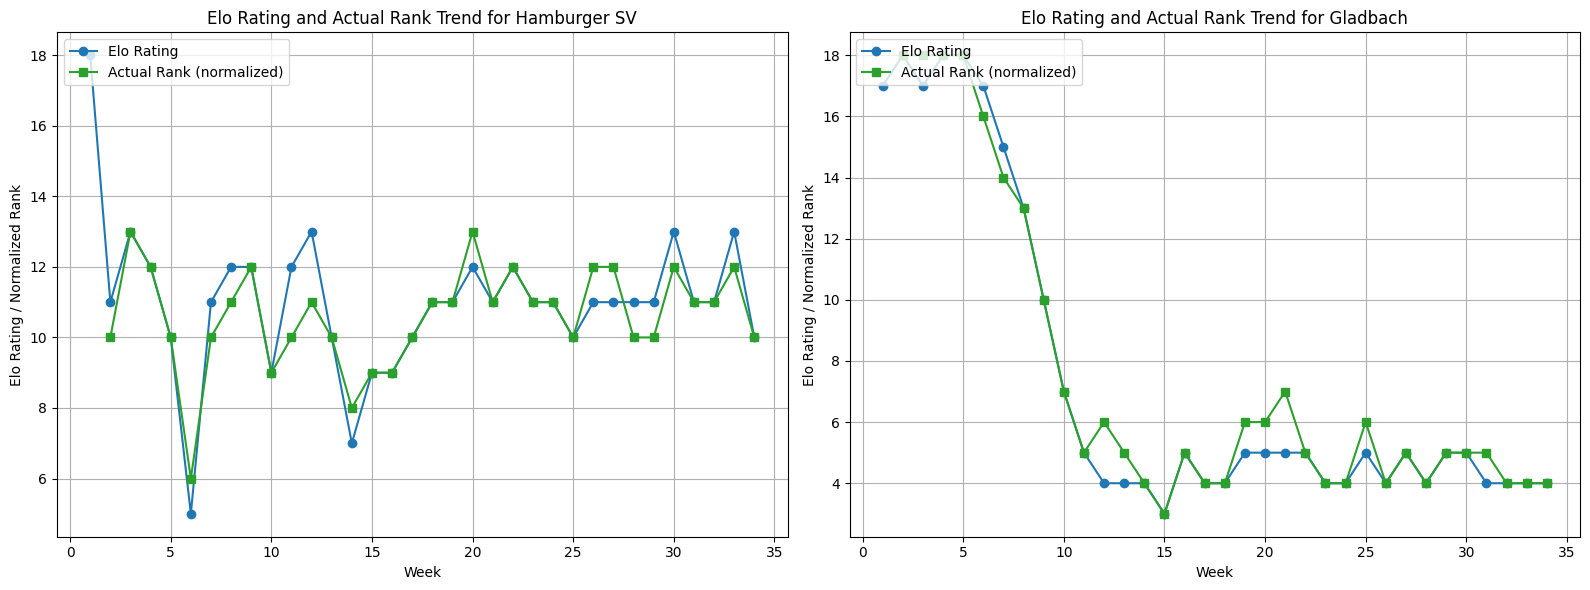

In [17]:

team_1 = "Hamburger SV"
team_2 = "Gladbach"

team_1_ratings = weekly_final_elo_ratings[weekly_final_elo_ratings['Team'] == team_1]
team_1_rankings = weekly_rankings[weekly_rankings['Team'] == team_1].groupby('Wk').agg({'rank': 'mean'}).reset_index()
team_2_ratings = weekly_final_elo_ratings[weekly_final_elo_ratings['Team'] == team_2]
team_2_rankings = weekly_rankings[weekly_rankings['Team'] == team_2].groupby('Wk').agg({'rank': 'mean'}).reset_index()
min_elo_1 = team_1_ratings['Rank'].min()
max_elo_1 = team_1_ratings['Rank'].max()
team_1_rankings['normalized_rank'] = min_elo_1 + (team_1_rankings['rank'] - team_1_rankings['rank'].min()) * (max_elo_1 - min_elo_1) / (team_1_rankings['rank'].max() - team_1_rankings['rank'].min())

min_elo_2 = team_2_ratings['Rank'].min()
max_elo_2 = team_2_ratings['Rank'].max()
team_2_rankings['normalized_rank'] = min_elo_2 + (team_2_rankings['rank'] - team_2_rankings['rank'].min()) * (max_elo_2 - min_elo_2) / (team_2_rankings['rank'].max() - team_2_rankings['rank'].min())
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(team_1_ratings['Week'], team_1_ratings['Rank'], marker='o', label='Elo Rating', color='tab:blue')
ax[0].plot(team_1_rankings['Wk'], team_1_rankings['rank'], marker='s', label='Actual Rank (normalized)', color='tab:green')
ax[0].set_title(f'Elo Rating and Actual Rank Trend for {team_1}')
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Elo Rating / Normalized Rank')
ax[0].legend(loc='upper left')
ax[0].grid(True)
ax[1].plot(team_2_ratings['Week'], team_2_ratings['Rank'], marker='o', label='Elo Rating', color='tab:blue')
ax[1].plot(team_2_rankings['Wk'], team_2_rankings['rank'], marker='s', label='Actual Rank (normalized)', color='tab:green')
ax[1].set_title(f'Elo Rating and Actual Rank Trend for {team_2}')
ax[1].set_xlabel('Week')
ax[1].set_ylabel('Elo Rating / Normalized Rank')
ax[1].legend(loc='upper left')
ax[1].grid(True)
plt.tight_layout()
plt.show()


# Summarize 

The two mentioned task were completed with following results: 

1. Final optimized ELO model was developed which predicted with RMSE 0.333 the final week ranking of the teams and Average RMSE of 0.71 for weekly prediction. Bayesian optimization results for K and S value search was found most accurate. Goal difference by weeks, season time scale found crucial factors. 

2. Hamburger SV away performance of 3-0 against Gladbach home ground is the most surprising win of the season 2015/2016.


